In [17]:
%matplotlib inline

# London tube dataset provided by: markdunne (github.com/markdunne)
# Bike dataset provided by: Transport for London

import colorsys
import random
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from bokeh.plotting import figure, show
from bokeh.resources import CDN
from bokeh.io import output_notebook
output_notebook( resources=CDN )
import math
import requests
import json
import time


pd.set_option('max_colwidth', 200)

Loading BokehJS ...

In [18]:
# Tube
lines       = pd.read_csv('london.lines.csv', index_col=0)
stations    = pd.read_csv('london.stations.csv', index_col=0)
stationsRein= pd.read_csv('london.stations.reindexed.csv', index_col=0)
connections = pd.read_csv('london.connections.csv')

# Bikes
bikeTripData = pd.read_csv('bikes/london-bikes-sorted.csv', index_col=0)       # http://cycling.data.tfl.gov.uk
bikeDockingStations = pd.read_csv('santander-cycle-coords.csv', index_col=0)   # https://tfl.gov.uk/tfl/syndication/feeds/cycle-hire/livecyclehireupdates.xml

# Uber
uberTripData = pd.read_csv('../uber/compiledUberData.csv', index_col=0)       # Uber API



In [19]:
# Tube Graph

tubeGraph = nx.Graph()

for connection_id, connection in connections.iterrows():
    line_name = lines.ix[connection.line]['name']
    station1_name = stations.ix[connection.station1]['name']
    station2_name = stations.ix[connection.station2]['name']

    #Oxford Circus - Central Line
    node1_name = "%s - %s" % (station1_name, line_name)
    node2_name = "%s - %s" % (station2_name, line_name)
    
    #"Bond Street - Central Line" to "Oxford Circus - Central Line"
    tubeGraph.add_edge(node1_name, node2_name,    time = connection['time'])
    
    #"Oxford Circus - Central Line" to "Oxford Circus"
    tubeGraph.add_edge(node1_name, station1_name, time = 2)
    tubeGraph.add_edge(node2_name, station2_name, time = 2)
    
    #"Oxford Circus - Central Line" to "Oxford Circus - Victoria Line"
    for neighbor in tubeGraph.neighbors(station1_name):
        tubeGraph.add_edge(node1_name, neighbor, time = 5)        
    for neighbor in tubeGraph.neighbors(station2_name):
        tubeGraph.add_edge(node2_name, neighbor, time = 5)
        
tubeGraph.add_edge('Bank', 'Monument', time = 1)

/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  import sys
/usr/local/Cellar/ipython/6.5.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [20]:
# Example Shortest Path
nx.shortest_path(tubeGraph, 'Oxford Circus', 'Canary Wharf', weight='time')

['Oxford Circus',
 'Oxford Circus - Victoria Line',
 'Green Park - Victoria Line',
 'Green Park',
 'Green Park - Jubilee Line',
 'Westminster - Jubilee Line',
 'Waterloo - Jubilee Line',
 'Southwark - Jubilee Line',
 'London Bridge - Jubilee Line',
 'Bermondsey - Jubilee Line',
 'Canada Water - Jubilee Line',
 'Canary Wharf - Jubilee Line',
 'Canary Wharf']

In [21]:
# You can do graphs things on the graph.
nx.algorithms.connectivity.cuts.minimum_node_cut(tubeGraph)

{'Marylebone - Bakerloo Line'}

In [22]:
# Divide bike data into different files for quicker processing
# or rather, store indices of start/stop of data.
startOfBikeDataStartStationSection = {}
startOfBikeDataStartStationSection[1] = 0

currId = 1
for station_id, station in bikeTripData.iterrows():
    if currId == station["StartStation Id"]:
        continue
    else:
        startOfBikeDataStartStationSection[currId+1] = station_id
        currId = currId + 1
        

In [23]:
# Calculates the farthest bike station from the center.

# maxDistance = 0
# maxStationName = ''
# maxStationId = -1

# # Center of London
# center = (51.510776, -0.115638)

# for id, station in bikeDockingStations.iterrows():
    
#     Lat = station["station__lat"]
#     Long = station["station__long"]
#     Distance = math.sqrt((Lat*(11/7))**2 + (Long)**2)
    
#     if Distance > maxDistance:
#         maxStationName = station["station__name"]
#         maxStationId = id
#         maxDistance = Distance
        
# print("Furthest Docking Station:",maxStationName, " - ",maxStationId)
# print(bikeDockingStations.at[maxStationId,"station__lat"], bikeDockingStations.at[maxStationId,"station__long"])


In [24]:
###################### START OF THE COMPUTATION #####################

In [25]:
# ------------- Get Random value and Mean -----------------

def randomCoordinate():
    # Calcuates mean coordinates based on Tube Stations
    latcoors = stationsRein['latitude']
    longcoors = stationsRein['longitude']
    latmean = latcoors.mean()
    longmean = longcoors.mean()

    #meancoors = (latmean, longmean)
    meancoors = (51.510776, -0.115638) # Center of London
    # print("Mean Coordinates: ", meancoors)

    latitudeBoundSize = 0.03  # Mess with these for bigger radius
    longitudeBoundSize = 0.1  # Mess with these for bigger radius

    randLat1 = meancoors[0] + (random.uniform(0,1)*latitudeBoundSize - (latitudeBoundSize/2))
    randLong1 = meancoors[1] + (random.uniform(0,1)*longitudeBoundSize - (longitudeBoundSize/2))
    randLat2 = meancoors[0] + (random.uniform(0,1)*latitudeBoundSize - (latitudeBoundSize/2))
    randLong2 = meancoors[1] + (random.uniform(0,1)*longitudeBoundSize - (longitudeBoundSize/2))

    print("Random origin location:        ", randLat1,"," ,randLong1)
    print("Random destination location:   ", randLat2,",", randLong2)
    
    return randLat1, randLong1, randLat2, randLong2

In [26]:
def getRandomBikeTrip():
    
    randIdx = -1
    dataPotentiallyDangerous = True
    while (dataPotentiallyDangerous):
        # Get random index between 0 and size of bikeTripData
        randIdx = random.randint(0,len(bikeTripData))
        
        dataPotentiallyDangerous = False
        
        # Try it
        try:
            randomStationId1 = int(bikeTripData.at[int(randIdx),"StartStation Id"])
            randomStationId2 = int(bikeTripData.at[int(randIdx),"EndStation Id"])
            bikeDockingStations.at[int(randomStationId1), "station__lat"]
            bikeDockingStations.at[int(randomStationId2), "station__lat"]
    
        except Exception:
            dataPotentiallyDangerous = True
            
        
    
    
    # Choose a random bike trip
    randomStationId1 = int(bikeTripData.at[int(randIdx),"StartStation Id"])
    randomStationId2 = int(bikeTripData.at[int(randIdx),"EndStation Id"])
    randomTripDuration = int(bikeTripData.at[int(randIdx),"Duration"])

    
    # Get the latitude and longitude of a trip
    randLat1  =  bikeDockingStations.at[int(randomStationId1), "station__lat"]
    randLong1 =  bikeDockingStations.at[int(randomStationId1), "station__long"]
    randLat2  =  bikeDockingStations.at[int(randomStationId2), "station__lat"]
    randLong2 =  bikeDockingStations.at[int(randomStationId2), "station__long"]
        
    
#     print(randomStationId1)
#     print(randomStationId2)
#     print(randomTripDuration/60)
    
    
    # Calculate the distance in miles.
    coorDistance = math.sqrt((randLat1 - randLat2)**2 + ((randLong1 - randLong2)*(70/111))**2)*(68.9722)
    
#     print(coorDistance)
    
    return randLat1, randLong1, randLat2, randLong2, randomStationId1, randomStationId2, coorDistance
    
    
getRandomBikeTrip()
    

(51.49016361, -0.19039362, 51.49313, -0.156876, 219, 5, 1.4721684188204733)

In [27]:
# --------------- Calculates the closest TUBE stations to the random coordinates --------------

def closestTubeStation(randLat1, randLong1, randLat2, randLong2):
    #calculate distances to all stations in array from co-ordinates
    tubeDistances1 = []
    tubeDistances2 = []
    for i in range(1, len(stationsRein['longitude'])):
        distance1 = math.sqrt(((randLat1 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong1 - stationsRein['longitude'].iloc[i-1])**2)
        distance2 = math.sqrt(((randLat2 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong2 - stationsRein['longitude'].iloc[i-1])**2)

        tubeDistances1.append(distance1)
        tubeDistances2.append(distance2)

    #pick shortest for each co-ordinate
    station1 = tubeDistances1.index(min(tubeDistances1))
    station2 = tubeDistances2.index(min(tubeDistances2))
    
    oName = stationsRein['name'][station1+1]
    oLat  = stationsRein['latitude'][station1+1]
    oLong = stationsRein['longitude'][station1+1]
    
    dName = stationsRein['name'][station2+1]
    dLat  = stationsRein['latitude'][station2+1]
    dLong = stationsRein['longitude'][station2+1]

    print("Nearest train station to Random Origin:",oName,oLat,oLong)
    print("Nearest train station to Random Destination:",dName,dLat,dLong)
    
    return oName, dName
    #return oName,oLat,oLong,dName,dLat,dLong

In [28]:
# ---------------- Calculate the closest BIKE station to the random coordinates ---------------

def closestBikeStation(randLat1, randLong1, randLat2, randLong2):

    shortestOriginID = -1
    shortestDestID = -1
    
    shortestBikeOriginValue = 9999
    shortestBikeDestinationValue = 9999

    for st_id, dockingStation in bikeDockingStations.iterrows():
        dockingID = st_id
        dockingLat  = dockingStation["station__lat"]
        dockingLong = dockingStation["station__long"]
        distanceFromRandomToOrigin      = math.sqrt(((randLat1 - dockingLat)*11/7)**2 + (randLong1 - dockingLong)**2)
        distanceFromRandomToDestination = math.sqrt(((randLat2 - dockingLat)*11/7)**2 + (randLong2 - dockingLong)**2)

        if distanceFromRandomToOrigin < shortestBikeOriginValue:
            shortestOriginID = dockingID
            shortestBikeOriginValue = distanceFromRandomToOrigin

        if distanceFromRandomToDestination < shortestBikeDestinationValue:
            shortestDestID = dockingID
            shortestBikeDestinationValue = distanceFromRandomToDestination

    print("Nearest bike station to Random Origin:", shortestOriginID)
    print("Nearest bike station to Random Destination:", shortestDestID)
    
    return shortestOriginID, shortestDestID

In [29]:
# ------------- Calculate BIKE travel time -----------------------
# Calculates the mean of the closest bike ports, as well as ones that are really close.

def calcBikeTravelTimeMins(oBikeStationID, dBikeStationID):
    exactMatches = 0
    #relativeMatches = 0
    totalDurationAllTrips = 0
    
    # Get the range of samples to look at 
    # As an optimization, only looked at the subset of data with the curent station station.
    try:
        lowerBound = startOfBikeDataStartStationSection[oBikeStationID]
        upperBound = startOfBikeDataStartStationSection[oBikeStationID +1] - 1
    except Exception:
        return -1
    
    if lowerBound == 0:
        lowerBound = 1
    
    print(oBikeStationID,lowerBound,upperBound)
    
    for i in range(lowerBound, upperBound):

        # Extract the trip data.
        tStartName =  bikeTripData.at[int(i),"StartStation Name"]
        tStartID =    bikeTripData.at[int(i),"StartStation Id"]

        tEndName   =  bikeTripData.at[int(i),"EndStation Name"]
        tEndID =  bikeTripData.at[int(i),"EndStation Id"]
        
        tDuration = bikeTripData.at[int(i),"Duration"]
        
        # If this trip exactly matches the given origin and dest.
        if oBikeStationID == tStartID and dBikeStationID == tEndID:
            exactMatches += 1
            totalDurationAllTrips += tDuration
            
            
    print("For bikes there were:",exactMatches, "exact matches.")
#   print("For bikes there were:",relativeMatches, "relative matches.")
    
    if exactMatches == 0:
        return -1 # ERROR! No matches...
    
    bikeMins = (totalDurationAllTrips / (exactMatches))/60
    print("The average time of this BIKE trip is:", bikeMins, "minutes.")
    
    
    return bikeMins

In [30]:
# --------------- Calculate TRAIN travel time --------------
# Calculates with dijkstra's shortest path algorithm (weighted by TIME)
def calcTrainTravelTimeMins(oName, dName):
    
    #nx.algorithms.shortest_paths.dijkstra_path(tubeGraph, oName, dName)

    quickestTrainTime = nx.algorithms.shortest_paths.dijkstra_path_length(tubeGraph,oName,dName, weight = "time")

    print("The quickest time for this TRAIN trip is ",quickestTrainTime, "minutes.")
    
    return quickestTrainTime

In [31]:
#### ------ Calculate how far the trip actually is------- ####

#distance1 = math.sqrt(((randLat1 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong1 - stationsRein['longitude'].iloc[i-1])**2)
#distance2 = math.sqrt(((randLat2 - stationsRein['latitude'].iloc[i-1])*(11/7))**2 + (randLong2 - stationsRein['longitude'].iloc[i-1])**2)

In [32]:
# Experiment: Bikes vs Trains

# ########## RUN ME ############
numIterations = 5000


# ##############################

mainTestOutput = {}
for i in range(0, numIterations):
    print("[!] Iteration", i)
    
    # Compute coordinates in our range
    #(randLat1, randLong1, randLat2, randLong2) = randomCoordinate()
    (randLat1, randLong1, randLat2, randLong2, oBike, dBike, coorDistance) = getRandomBikeTrip()

    # Calculate the nearest origin and destination stations, given the random coordinates.
    (oTrain,dTrain) = closestTubeStation(randLat1, randLong1, randLat2, randLong2)
##    (oBike, dBike) = closestBikeStation(randLat1, randLong1, randLat2, randLong2)

    # Calculate the minimum/average travel time (with our data) given an origin and a destination.
    trainMins = calcTrainTravelTimeMins(oTrain,dTrain)
    bikeMins = calcBikeTravelTimeMins(oBike, dBike)

    if bikeMins == -1 or trainMins == -1 or (oTrain == dTrain):
        print("Skipping this one.")
        continue
        
    mainTestOutput[i] = {"oRandomLat": randLat1,
                 "oRandomLong": randLong1,
                 "dRandomLat": randLat2,
                 "dRandomLong": randLong2,
                 "coorDistance": coorDistance,
                 "oTrain": oTrain, 
                 "dTrain": dTrain,
                 "oBike": oBike,
                 "dBike": dBike,
                 "bikeMins": bikeMins,
                 "trainMins": trainMins}
    
mainTestOutputDF = pd.DataFrame.from_dict(mainTestOutput, orient="index")



[!] Iteration 0
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  13 minutes.
737 285524 286322
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 18.666666666666668 minutes.
[!] Iteration 1
Nearest train station to Random Origin: Knightsbridge 51.5015 -0.1607
Nearest train station to Random Destination: Queensway 51.5107 -0.1877
The quickest time for this TRAIN trip is  23 minutes.
303 146167 147599
For bikes there were: 80 exact matches.
The average time of this BIKE trip is: 25.4625 minutes.
[!] Iteration 2
Nearest train station to Random Origin: Vauxhall 51.4861 -0.1253
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  23 minutes.
270 132609 133583
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 17.333333333333332 minutes.


Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  6 minutes.
675 266345 266564
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 30
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  17 minutes.
66 33223 34180
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 8.5 minutes.
[!] Iteration 31
Nearest train station to Random Origin: Russell Square 51.523 -0.1244
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  12 minutes.
11 3703 4155
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 32
Nearest train station to Random Origin: Hyd

Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: Clapham Common 51.4618 -0.1384
The quickest time for this TRAIN trip is  0 minutes.
664 263440 263750
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 33.09090909090909 minutes.
Skipping this one.
[!] Iteration 57
Nearest train station to Random Origin: Covent Garden 51.5129 -0.1243
Nearest train station to Random Destination: Bayswater 51.5121 -0.1879
The quickest time for this TRAIN trip is  27 minutes.
335 159097 159848
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 28.0 minutes.
[!] Iteration 58
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Latimer Road 51.5139 -0.2172
The quickest time for this TRAIN trip is  20 minutes.
155 78610 79002
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!]

Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  8 minutes.
326 155597 156269
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 7.888888888888888 minutes.
[!] Iteration 86
Nearest train station to Random Origin: Mornington Crescent 51.5342 -0.1387
Nearest train station to Random Destination: Borough 51.5011 -0.0943
The quickest time for this TRAIN trip is  21 minutes.
362 171499 171830
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 22.6 minutes.
[!] Iteration 87
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: Embankment 51.5074 -0.1223
The quickest time for this TRAIN trip is  21 minutes.
237 118856 119267
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 18.75 minutes.
[!] Iteration 88
Nearest train station to 

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 28.0 minutes.
[!] Iteration 113
Nearest train station to Random Origin: Westferry 51.5097 -0.0265
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  18 minutes.
811 308300 308682
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 42.0 minutes.
[!] Iteration 114
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  0 minutes.
653 260304 260630
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 14.4 minutes.
Skipping this one.
[!] Iteration 115
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  19 minutes.
2 284 750
For 

For bikes there were: 397 exact matches.
The average time of this BIKE trip is: 55.26196473551637 minutes.
Skipping this one.
[!] Iteration 141
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Oval 51.4819 -0.113
The quickest time for this TRAIN trip is  25 minutes.
345 163688 164129
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 142
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  8 minutes.
215 107098 108057
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 143
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  8 minutes.
513 219169 219495
F

Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  18 minutes.
220 110788 111044
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 22.0 minutes.
[!] Iteration 173
Nearest train station to Random Origin: Temple 51.5111 -0.1141
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  20 minutes.
594 243705 244124
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 174
Nearest train station to Random Origin: Mornington Crescent 51.5342 -0.1387
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  8 minutes.
362 171499 171830
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 14.375 minutes.
[!] Iteration 1

Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  17 minutes.
2 284 750
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 52.90909090909091 minutes.
[!] Iteration 203
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: West Kensington 51.4907 -0.2065
The quickest time for this TRAIN trip is  9 minutes.
187 91454 91836
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 10.25 minutes.
[!] Iteration 204
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Wapping 51.5043 -0.0558
The quickest time for this TRAIN trip is  15 minutes.
818 310039 310539
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.5 minutes.
[!] Iteration 205
Nearest t

For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 6.2 minutes.
[!] Iteration 233
Nearest train station to Random Origin: Aldgate East 51.5154 -0.0726
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  20 minutes.
537 225278 225630
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 24.25 minutes.
[!] Iteration 234
Nearest train station to Random Origin: West Kensington 51.4907 -0.2065
Nearest train station to Random Destination: Ravenscourt Park 51.4942 -0.2359
The quickest time for this TRAIN trip is  9 minutes.
626 252811 253272
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 16.285714285714285 minutes.
[!] Iteration 235
Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Bow Church 51.5273 -0.0208
The quickest time for this TRAIN trip is  27 minutes.
779 297139 297501
For b

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 30.5 minutes.
[!] Iteration 263
Nearest train station to Random Origin: Bank 51.5133 -0.0886
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  8 minutes.
340 160931 161844
For bikes there were: 49 exact matches.
The average time of this BIKE trip is: 12.122448979591837 minutes.
[!] Iteration 264
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  0 minutes.
24 13113 13826
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 64.0 minutes.
Skipping this one.
[!] Iteration 265
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Euston Square 51.526 -0.1359
The quickest time for this TRAIN trip is  14 minutes.
372 173953 174333
For bikes there were: 4 exact

Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  14 minutes.
107 53876 54837
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 3.6666666666666665 minutes.
[!] Iteration 292
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  15 minutes.
423 191380 191611
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 22.0 minutes.
[!] Iteration 293
Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  22 minutes.
290 140957 141740
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 21.833333333333332 minutes.
[!] Iteration 294
Neares

Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  0 minutes.
157 79274 79909
For bikes there were: 33 exact matches.
The average time of this BIKE trip is: 2.696969696969697 minutes.
Skipping this one.
[!] Iteration 329
Nearest train station to Random Origin: Wapping 51.5043 -0.0558
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  17 minutes.
458 203322 203740
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 14.916666666666666 minutes.
[!] Iteration 330
Nearest train station to Random Origin: Leicester Square 51.5113 -0.1281
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  6 minutes.
325 155296 155596
For bikes there were: 5 exact matches.
The average time of this 

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  15 minutes.
58 30360 30927
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 10.6 minutes.
[!] Iteration 359
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Edgware Road (C) 51.5203 -0.17
The quickest time for this TRAIN trip is  20 minutes.
189 92167 92489
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 360
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  22 minutes.
273 134839 135277
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 9.4 minutes.
[!] Iteration 361
Nearest train station to Random Origin: King's

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 4.0 minutes.
Skipping this one.
[!] Iteration 389
Nearest train station to Random Origin: Leyton 51.5566 -0.0053
Nearest train station to Random Destination: Stratford 51.5416 -0.0042
The quickest time for this TRAIN trip is  6 minutes.
812 308683 308840
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 57.666666666666664 minutes.
[!] Iteration 390
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  15 minutes.
371 173826 173952
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 18.5 minutes.
[!] Iteration 391
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  9 minutes.
427 192626 193842


Nearest train station to Random Destination: Latimer Road 51.5139 -0.2172
The quickest time for this TRAIN trip is  28 minutes.
566 234490 234603
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 423
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  11 minutes.
169 84333 84903
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 424
Nearest train station to Random Origin: Clapham South 51.4527 -0.14800000000000002
Nearest train station to Random Destination: Notting Hill Gate 51.5094 -0.1967
The quickest time for this TRAIN trip is  36 minutes.
672 265861 265876
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iteration 425
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest tra

Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  16 minutes.
512 218542 219168
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 22.333333333333332 minutes.
[!] Iteration 455
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN trip is  21 minutes.
793 302453 302722
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 456
Nearest train station to Random Origin: Goodge Street 51.5205 -0.1347
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  18 minutes.
12 4156 5104
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 13.5 minutes.
[!] Iteration 457
Nearest train station to Random Origin: South Kensington 51.4941 -

Nearest train station to Random Origin: East Putney 51.4586 -0.2112
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  9 minutes.
621 251054 251378
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 483
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  5 minutes.
30 16315 16789
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 5.75 minutes.
[!] Iteration 484
Nearest train station to Random Origin: Knightsbridge 51.5015 -0.1607
Nearest train station to Random Destination: Regent's Park 51.5234 -0.1466
The quickest time for this TRAIN trip is  17 minutes.
303 146167 147599
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 485
Nearest train station to Random O

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 3.0 minutes.
Skipping this one.
[!] Iteration 513
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  21 minutes.
445 199243 199536
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 5.333333333333333 minutes.
[!] Iteration 514
Nearest train station to Random Origin: Aldgate East 51.5154 -0.0726
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  12 minutes.
200 100477 100845
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 515
Nearest train station to Random Origin: Limehouse 51.5123 -0.0396
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  6 minutes.
542 227555

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 22.0 minutes.
[!] Iteration 543
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  0 minutes.
737 285524 286322
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 38.0 minutes.
Skipping this one.
[!] Iteration 544
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  0 minutes.
321 153689 154405
For bikes there were: 29 exact matches.
The average time of this BIKE trip is: 2.827586206896552 minutes.
Skipping this one.
[!] Iteration 545
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN tri

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  22 minutes.
73 37230 38298
For bikes there were: 33 exact matches.
The average time of this BIKE trip is: 7.545454545454546 minutes.
[!] Iteration 568
Nearest train station to Random Origin: Westminster 51.501000000000005 -0.1254
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  16 minutes.
583 240220 240838
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 28.0 minutes.
[!] Iteration 569
Nearest train station to Random Origin: Bond Street 51.5142 -0.1494
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  14 minutes.
141 71382 71848
For bikes there were: 30 exact matches.
The average time of this BIKE trip is: 13.866666666666667 minutes.
[!] 

Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  7 minutes.
507 216647 216843
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 594
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  14 minutes.
800 304779 305200
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 23.6 minutes.
[!] Iteration 595
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Covent Garden 51.5129 -0.1243
The quickest time for this TRAIN trip is  19 minutes.
324 154878 155295
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 16.25 minutes.
[!] Iteration 596
Nearest train 

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  0 minutes.
42 22168 22698
For bikes there were: 22 exact matches.
The average time of this BIKE trip is: 4.181818181818182 minutes.
Skipping this one.
[!] Iteration 626
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  16 minutes.
641 257114 257339
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 41.0 minutes.
[!] Iteration 627
Nearest train station to Random Origin: Wapping 51.5043 -0.0558
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  17 minutes.
451 201374 201610
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 10.125 minutes.
[!] Iteration 62

For bikes there were: 538 exact matches.
The average time of this BIKE trip is: 58.026022304832715 minutes.
Skipping this one.
[!] Iteration 655
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  20 minutes.
195 97852 98676
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 656
Nearest train station to Random Origin: Stockwell 51.4723 -0.12300000000000001
Nearest train station to Random Destination: Stockwell 51.4723 -0.12300000000000001
The quickest time for this TRAIN trip is  0 minutes.
828 311583 311631
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
Skipping this one.
[!] Iteration 657
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this T

Nearest train station to Random Origin: Vauxhall 51.4861 -0.1253
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  18 minutes.
310 150304 150653
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 7.5 minutes.
[!] Iteration 682
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  5 minutes.
183 89712 90104
For bikes there were: 75 exact matches.
The average time of this BIKE trip is: 5.7733333333333325 minutes.
[!] Iteration 683
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  14 minutes.
465 205442 206081
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 344.42857142857144 minutes.
[!] Iteration 684
Nearest t

Nearest train station to Random Origin: Kennington 51.4884 -0.1053
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  18 minutes.
144 72498 73033
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 708
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  15 minutes.
426 192376 192625
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 709
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  11 minutes.
457 202833 203321
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 19.714285714285715 minutes.
[!] Iteration 710
Nearest train station to Random

Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  19 minutes.
204 102878 103185
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 742
Nearest train station to Random Origin: Baker Street 51.5226 -0.1571
Nearest train station to Random Destination: Marylebone 51.5225 -0.1631
The quickest time for this TRAIN trip is  5 minutes.
257 128029 128309
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 3.1666666666666665 minutes.
[!] Iteration 743
Nearest train station to Random Origin: Mornington Crescent 51.5342 -0.1387
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  18 minutes.
131 66149 66415
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 36.0 minutes.
[!] Iteration 744
Nearest train sta

Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  19 minutes.
517 220264 220520
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 20.5 minutes.
[!] Iteration 767
Nearest train station to Random Origin: Euston Square 51.526 -0.1359
Nearest train station to Random Destination: Leicester Square 51.5113 -0.1281
The quickest time for this TRAIN trip is  16 minutes.
19 11152 11572
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 10.166666666666666 minutes.
[!] Iteration 768
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Stockwell 51.4723 -0.12300000000000001
The quickest time for this TRAIN trip is  8 minutes.
614 249242 249414
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 769
Nearest train

For bikes there were: 23 exact matches.
The average time of this BIKE trip is: 9.434782608695652 minutes.
Skipping this one.
[!] Iteration 796
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  13 minutes.
66 33223 34180
For bikes there were: 37 exact matches.
The average time of this BIKE trip is: 9.35135135135135 minutes.
[!] Iteration 797
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  8 minutes.
167 83362 84134
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 798
Nearest train station to Random Origin: Baker Street 51.5226 -0.1571
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  10 mi

The quickest time for this TRAIN trip is  12 minutes.
144 72498 73033
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 17.8 minutes.
[!] Iteration 829
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  14 minutes.
93 45968 46350
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 14.25 minutes.
[!] Iteration 830
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  0 minutes.
111 56558 57692
For bikes there were: 298 exact matches.
The average time of this BIKE trip is: 53.36241610738255 minutes.
Skipping this one.
[!] Iteration 831
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for 

Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  0 minutes.
746 287800 288011
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 3.9 minutes.
Skipping this one.
[!] Iteration 865
Nearest train station to Random Origin: Clapham South 51.4527 -0.14800000000000002
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  35 minutes.
638 255800 256467
For bikes there were: 39 exact matches.
The average time of this BIKE trip is: 7.3076923076923075 minutes.
[!] Iteration 866
Nearest train station to Random Origin: Royal Oak 51.519 -0.188
Nearest train station to Random Destination: Westbourne Park 51.521 -0.2011
The quickest time for this TRAIN trip is  6 minutes.
592 243097 243386
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 10.0 min

Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  11 minutes.
126 63698 64358
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 11.5 minutes.
[!] Iteration 897
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  15 minutes.
96 47744 48035
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 898
Nearest train station to Random Origin: Goldhawk Road 51.5018 -0.2267
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  35 minutes.
657 261157 261351
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 68.0 minutes.
[!] Iteration 899
Nearest train station to Random Origin

For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 6.705882352941177 minutes.
[!] Iteration 931
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  22 minutes.
14 5428 8543
For bikes there were: 20 exact matches.
The average time of this BIKE trip is: 10.85 minutes.
[!] Iteration 932
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  25 minutes.
769 294857 295158
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 32.0 minutes.
[!] Iteration 933
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The quickest time for this TRAIN trip is  12 minutes.
449 200535 20

Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  0 minutes.
489 211609 212100
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 2.444444444444444 minutes.
Skipping this one.
[!] Iteration 961
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  12 minutes.
546 228722 229220
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 12.5 minutes.
[!] Iteration 962
Nearest train station to Random Origin: West Kensington 51.4907 -0.2065
Nearest train station to Random Destination: West Kensington 51.4907 -0.2065
The quickest time for this TRAIN trip is  0 minutes.
626 252811 253272
For bikes there were: 7 exact matches.
The average time of this BIKE trip is:

78 40336 40904
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 5.235294117647059 minutes.
[!] Iteration 994
Nearest train station to Random Origin: West Brompton 51.4872 -0.1953
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  10 minutes.
219 110288 110787
For bikes there were: 16 exact matches.
The average time of this BIKE trip is: 7.5 minutes.
[!] Iteration 995
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  12 minutes.
10 3466 3702
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 9.75 minutes.
[!] Iteration 996
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: West Brompton 51.4872 -0.1953
The quickest time for this TRAIN trip is  9 minutes.

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 21.5 minutes.
[!] Iteration 1023
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  25 minutes.
533 223794 224196
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 17.8 minutes.
[!] Iteration 1024
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: West Brompton 51.4872 -0.1953
The quickest time for this TRAIN trip is  9 minutes.
157 79274 79909
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 7.666666666666667 minutes.
[!] Iteration 1025
Nearest train station to Random Origin: Stepney Green 51.5221 -0.047
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  13 minutes.
478 207795 208353


The quickest time for this TRAIN trip is  28 minutes.
744 287531 287589
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 51.0 minutes.
[!] Iteration 1055
Nearest train station to Random Origin: All Saints 51.5107 -0.013000000000000001
Nearest train station to Random Destination: Stepney Green 51.5221 -0.047
The quickest time for this TRAIN trip is  25 minutes.
523 221755 221817
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 1056
Nearest train station to Random Origin: Bow Church 51.5273 -0.0208
Nearest train station to Random Destination: Stratford 51.5416 -0.0042
The quickest time for this TRAIN trip is  8 minutes.
495 213390 213680
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 24.4 minutes.
[!] Iteration 1057
Nearest train station to Random Origin: West Kensington 51.4907 -0.2065
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quicke

For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 12.2 minutes.
[!] Iteration 1090
Nearest train station to Random Origin: Canary Wharf 51.5051 -0.0209
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  22 minutes.
448 200151 200534
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 27.166666666666668 minutes.
[!] Iteration 1091
Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  13 minutes.
263 129393 129845
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 1092
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  20 minutes.
254 126927 127482
For bikes there were: 3 e

The quickest time for this TRAIN trip is  17 minutes.
112 57693 58207
For bikes there were: 16 exact matches.
The average time of this BIKE trip is: 6.5625 minutes.
[!] Iteration 1123
Nearest train station to Random Origin: Monument 51.5108 -0.0863
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  10 minutes.
587 241321 241932
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 1124
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Kennington 51.4884 -0.1053
The quickest time for this TRAIN trip is  17 minutes.
376 176730 177332
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
[!] Iteration 1125
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Mornington Crescent 51.5342 -0.1387
The quickest time for this 

For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 4.75 minutes.
[!] Iteration 1155
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  17 minutes.
126 63698 64358
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 1156
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  0 minutes.
819 310540 310895
For bikes there were: 18 exact matches.
The average time of this BIKE trip is: 44.38888888888889 minutes.
Skipping this one.
[!] Iteration 1157
Nearest train station to Random Origin: St. John's Wood 51.5347 -0.174
Nearest train station to Random Destination: St. John's Wood 51.5347 -0.174
The quickest time for this TRAIN trip is  0 minutes.
247 122449 122694
For bik

Nearest train station to Random Origin: Marylebone 51.5225 -0.1631
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  15 minutes.
759 291689 291856
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 8.5 minutes.
[!] Iteration 1181
Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: Bond Street 51.5142 -0.1494
The quickest time for this TRAIN trip is  16 minutes.
186 90963 91453
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 12.666666666666666 minutes.
[!] Iteration 1182
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Euston Square 51.526 -0.1359
The quickest time for this TRAIN trip is  15 minutes.
748 288355 288770
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 23.5 minutes.
[!] Iteration 1183
Nearest train stati

768 294541 294856
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 21.0 minutes.
[!] Iteration 1213
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  0 minutes.
321 153689 154405
For bikes there were: 29 exact matches.
The average time of this BIKE trip is: 2.827586206896552 minutes.
Skipping this one.
[!] Iteration 1214
Nearest train station to Random Origin: Green Park 51.5067 -0.1428
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  11 minutes.
53 27477 27733
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 7.666666666666667 minutes.
[!] Iteration 1215
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip

428 193843 194664
For bikes there were: 21 exact matches.
The average time of this BIKE trip is: 13.476190476190476 minutes.
[!] Iteration 1244
Nearest train station to Random Origin: Hammersmith 51.4936 -0.2251
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  16 minutes.
595 244125 244510
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 46.0 minutes.
[!] Iteration 1245
Nearest train station to Random Origin: Whitechapel 51.5194 -0.0612
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  22 minutes.
500 214657 215131
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 27.5 minutes.
[!] Iteration 1246
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  21 minutes.
479 208354 

Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  21 minutes.
512 218542 219168
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 10.714285714285715 minutes.
[!] Iteration 1272
Nearest train station to Random Origin: Whitechapel 51.5194 -0.0612
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  17 minutes.
206 103187 103754
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 71.0 minutes.
[!] Iteration 1273
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Regent's Park 51.5234 -0.1466
The quickest time for this TRAIN trip is  15 minutes.
14 5428 8543
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 11.4 minutes.
[!] Iteration 1274
Near

[!] Iteration 1303
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  22 minutes.
185 90565 90962
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 28.0 minutes.
[!] Iteration 1304
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  12 minutes.
359 169272 169564
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 9.5 minutes.
[!] Iteration 1305
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  11 minutes.
345 163688 164129
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 7.333333333333333 minutes.
[!] Iterati

Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  17 minutes.
101 50037 51387
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 17.333333333333332 minutes.
[!] Iteration 1340
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  22 minutes.
40 21077 21431
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 18.5 minutes.
[!] Iteration 1341
Nearest train station to Random Origin: Edgware Road (C) 51.5203 -0.17
Nearest train station to Random Destination: St. John's Wood 51.5347 -0.174
The quickest time for this TRAIN trip is  15 minutes.
402 186376 186535
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 1342
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train statio

For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 1371
Nearest train station to Random Origin: Limehouse 51.5123 -0.0396
Nearest train station to Random Destination: Monument 51.5108 -0.0863
The quickest time for this TRAIN trip is  9 minutes.
483 209705 210053
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 13.75 minutes.
[!] Iteration 1372
Nearest train station to Random Origin: Stockwell 51.4723 -0.12300000000000001
Nearest train station to Random Destination: Stockwell 51.4723 -0.12300000000000001
The quickest time for this TRAIN trip is  0 minutes.
714 277802 277898
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 5.666666666666667 minutes.
Skipping this one.
[!] Iteration 1373
Nearest train station to Random Origin: Leicester Square 51.5113 -0.1281
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  20

Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  0 minutes.
5 1610 2263
For bikes there were: 20 exact matches.
The average time of this BIKE trip is: 10.95 minutes.
Skipping this one.
[!] Iteration 1407
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  19 minutes.
815 309156 309646
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 19.2 minutes.
[!] Iteration 1408
Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  0 minutes.
522 221491 221754
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 35.88235294117647 minutes.
Skipping this one.

Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: West Kensington 51.4907 -0.2065
The quickest time for this TRAIN trip is  8 minutes.
384 179940 180104
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 68.83333333333333 minutes.
[!] Iteration 1435
Nearest train station to Random Origin: Stockwell 51.4723 -0.12300000000000001
Nearest train station to Random Destination: Stockwell 51.4723 -0.12300000000000001
The quickest time for this TRAIN trip is  0 minutes.
630 253714 253901
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 44.0 minutes.
Skipping this one.
[!] Iteration 1436
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  14 minutes.
715 277899 278125
For bikes there were: 1 exact matches.
The average time of thi

For bikes there were: 45 exact matches.
The average time of this BIKE trip is: 5.466666666666667 minutes.
Skipping this one.
[!] Iteration 1459
Nearest train station to Random Origin: Westferry 51.5097 -0.0265
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  21 minutes.
716 278126 278314
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iteration 1460
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  17 minutes.
645 258005 258396
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 4.571428571428571 minutes.
[!] Iteration 1461
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  

171 85258 85509
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 1484
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  16 minutes.
327 156270 156444
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 1485
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Aldgate 51.5143 -0.0755
The quickest time for this TRAIN trip is  17 minutes.
464 205306 205441
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 20.8 minutes.
[!] Iteration 1486
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Bank 51.5133 -0.0886
The quickest time for this TRAIN trip is  6 minutes.
489 211609 212100
F

Nearest train station to Random Origin: Russell Square 51.523 -0.1244
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  14 minutes.
89 44839 45297
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 9.333333333333334 minutes.
[!] Iteration 1520
Nearest train station to Random Origin: Warwick Avenue 51.5235 -0.1835
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  22 minutes.
47 24810 25298
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 15.333333333333334 minutes.
[!] Iteration 1521
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Hammersmith 51.4936 -0.2251
The quickest time for this TRAIN trip is  11 minutes.
392 181964 182576
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 19.666666666666668 minutes.

For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 47.8 minutes.
Skipping this one.
[!] Iteration 1555
Nearest train station to Random Origin: Tower Hill 51.5098 -0.0766
Nearest train station to Random Destination: All Saints 51.5107 -0.013000000000000001
The quickest time for this TRAIN trip is  21 minutes.
104 52009 53266
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 15.333333333333334 minutes.
[!] Iteration 1556
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  10 minutes.
589 242199 242664
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 5.222222222222222 minutes.
[!] Iteration 1557
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  15 m

14 5428 8543
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 18.076923076923077 minutes.
[!] Iteration 1583
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Westminster 51.501000000000005 -0.1254
The quickest time for this TRAIN trip is  12 minutes.
160 80923 81500
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 18.5 minutes.
[!] Iteration 1584
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  0 minutes.
762 292324 293473
For bikes there were: 20 exact matches.
The average time of this BIKE trip is: 20.05 minutes.
Skipping this one.
[!] Iteration 1585
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time 

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  22 minutes.
32 17251 18120
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 21.0 minutes.
[!] Iteration 1613
Nearest train station to Random Origin: Edgware Road (B) 51.5199 -0.1679
Nearest train station to Random Destination: Clapham Common 51.4618 -0.1384
The quickest time for this TRAIN trip is  33 minutes.
367 173074 173322
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iteration 1614
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Tower Gateway 51.5106 -0.0743
The quickest time for this TRAIN trip is  17 minutes.
230 116066 116548
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 21.2 minutes.
[!] Iteration 1615
Nearest train station to R

444 198875 199242
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 18.5 minutes.
[!] Iteration 1642
Nearest train station to Random Origin: Chalk Farm 51.5441 -0.1538
Nearest train station to Random Destination: Great Portland Street 51.5238 -0.1439
The quickest time for this TRAIN trip is  19 minutes.
271 133584 133862
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.333333333333334 minutes.
[!] Iteration 1643
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Russell Square 51.523 -0.1244
The quickest time for this TRAIN trip is  20 minutes.
501 215132 215452
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 23.0 minutes.
[!] Iteration 1644
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  6 minutes.
107 53876

For bikes there were: 538 exact matches.
The average time of this BIKE trip is: 58.026022304832715 minutes.
Skipping this one.
[!] Iteration 1671
Nearest train station to Random Origin: Liverpool Street 51.5178 -0.0823
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  9 minutes.
41 21432 22167
For bikes there were: 28 exact matches.
The average time of this BIKE trip is: 6.5357142857142865 minutes.
[!] Iteration 1672
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Queensway 51.5107 -0.1877
The quickest time for this TRAIN trip is  21 minutes.
213 105171 106451
For bikes there were: 37 exact matches.
The average time of this BIKE trip is: 50.83783783783784 minutes.
[!] Iteration 1673
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN 

For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 43.333333333333336 minutes.
[!] Iteration 1698
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Borough 51.5011 -0.0943
The quickest time for this TRAIN trip is  20 minutes.
185 90565 90962
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 1699
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  15 minutes.
215 107098 108057
For bikes there were: 31 exact matches.
The average time of this BIKE trip is: 9.161290322580644 minutes.
[!] Iteration 1700
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  22 minutes.
73 37230 38298
For bikes there 

Nearest train station to Random Origin: Westferry 51.5097 -0.0265
Nearest train station to Random Destination: Devons Road 51.5223 -0.0173
The quickest time for this TRAIN trip is  10 minutes.
460 204098 204394
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 1724
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  6 minutes.
780 297502 297979
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 13.666666666666666 minutes.
[!] Iteration 1725
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Clapham South 51.4527 -0.14800000000000002
The quickest time for this TRAIN trip is  35 minutes.
701 273773 274215
For bikes there were: 50 exact matches.
The average time of this BIKE trip is: 4.72 minutes.
[!] Iteration

Nearest train station to Random Origin: Westferry 51.5097 -0.0265
Nearest train station to Random Destination: Mudchute 51.4902 -0.0145
The quickest time for this TRAIN trip is  16 minutes.
510 217744 218139
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 1754
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  16 minutes.
549 229523 229767
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 1755
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  17 minutes.
112 57693 58207
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 1756
Nearest train station to Random 

For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
[!] Iteration 1780
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  18 minutes.
203 102143 102877
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 19.333333333333332 minutes.
[!] Iteration 1781
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  19 minutes.
511 218140 218541
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 27.833333333333332 minutes.
[!] Iteration 1782
Nearest train station to Random Origin: Vauxhall 51.4861 -0.1253
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  14 minute

The quickest time for this TRAIN trip is  15 minutes.
83 42122 42625
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 8.5 minutes.
[!] Iteration 1811
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Warren Street 51.5247 -0.1384
The quickest time for this TRAIN trip is  18 minutes.
193 95600 96367
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iteration 1812
Nearest train station to Random Origin: Canary Wharf 51.5051 -0.0209
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  29 minutes.
448 200151 200534
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 31.0 minutes.
[!] Iteration 1813
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time f

The quickest time for this TRAIN trip is  24 minutes.
55 28212 29513
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 20.57142857142857 minutes.
[!] Iteration 1838
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  13 minutes.
345 163688 164129
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 1839
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  9 minutes.
213 105171 106451
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iteration 1840
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quic

For bikes there were: 22 exact matches.
The average time of this BIKE trip is: 9.909090909090908 minutes.
[!] Iteration 1864
Nearest train station to Random Origin: Edgware Road (B) 51.5199 -0.1679
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  20 minutes.
188 91837 92166
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 1865
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  12 minutes.
723 280748 281215
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 1866
Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  17 minutes.
531 223113 223512
For bikes th

The average time of this BIKE trip is: 10.142857142857142 minutes.
[!] Iteration 1890
Nearest train station to Random Origin: Regent's Park 51.5234 -0.1466
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  12 minutes.
242 120334 120717
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 1891
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Embankment 51.5074 -0.1223
The quickest time for this TRAIN trip is  19 minutes.
511 218140 218541
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 18.5 minutes.
[!] Iteration 1892
Nearest train station to Random Origin: Oxford Circus 51.515 -0.1415
Nearest train station to Random Destination: Edgware Road (B) 51.5199 -0.1679
The quickest time for this TRAIN trip is  11 minutes.
116 59622 60398
For bikes there were: 6 exact matches.


Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  15 minutes.
579 238663 239422
For bikes there were: 31 exact matches.
The average time of this BIKE trip is: 5.0 minutes.
[!] Iteration 1924
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  16 minutes.
324 154878 155295
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 1925
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Earl's Court 51.492 -0.1973
The quickest time for this TRAIN trip is  7 minutes.
277 136151 136574
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 13.2 minutes.
[!] Iteration 1926
Nearest train station to Random Origin: Green Park 51.5067 -0.1428
Nearest train sta

For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 80.4 minutes.
[!] Iteration 1950
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  18 minutes.
154 75813 78609
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 1951
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  0 minutes.
191 92980 94943
For bikes there were: 538 exact matches.
The average time of this BIKE trip is: 58.026022304832715 minutes.
Skipping this one.
[!] Iteration 1952
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  10 minutes.
574 237025 237

Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Bond Street 51.5142 -0.1494
The quickest time for this TRAIN trip is  12 minutes.
421 190740 191378
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 24.0 minutes.
[!] Iteration 1976
Nearest train station to Random Origin: Notting Hill Gate 51.5094 -0.1967
Nearest train station to Random Destination: Westbourne Park 51.521 -0.2011
The quickest time for this TRAIN trip is  15 minutes.
225 112770 113560
For bikes there were: 72 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 1977
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  14 minutes.
195 97852 98676
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 2.5 minutes.
[!] Iteration 1978
Nearest train s

Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  15 minutes.
230 116066 116548
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 2002
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  18 minutes.
273 134839 135277
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 14.75 minutes.
[!] Iteration 2003
Nearest train station to Random Origin: Earl's Court 51.492 -0.1973
Nearest train station to Random Destination: West Brompton 51.4872 -0.1953
The quickest time for this TRAIN trip is  6 minutes.
158 79910 80214
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 6.5 minutes.
[!] Iteration 2004
Nearest train station to Random Ori

Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Marylebone 51.5225 -0.1631
The quickest time for this TRAIN trip is  15 minutes.
514 219496 219884
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 5.25 minutes.
[!] Iteration 2036
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  8 minutes.
227 113976 114387
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 7.6 minutes.
[!] Iteration 2037
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Aldgate East 51.5154 -0.0726
The quickest time for this TRAIN trip is  10 minutes.
215 107098 108057
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 2038
Nearest train station to R

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 21.5 minutes.
[!] Iteration 2067
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  11 minutes.
466 206082 206370
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 2068
Nearest train station to Random Origin: Regent's Park 51.5234 -0.1466
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  19 minutes.
242 120334 120717
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 13.333333333333334 minutes.
[!] Iteration 2069
Nearest train station to Random Origin: St. Paul's 51.5146 -0.0973
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  12 minutes.
557 232022 2

For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 2.8571428571428568 minutes.
[!] Iteration 2095
Nearest train station to Random Origin: Limehouse 51.5123 -0.0396
Nearest train station to Random Destination: Wapping 51.5043 -0.0558
The quickest time for this TRAIN trip is  11 minutes.
483 209705 210053
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 7.8 minutes.
[!] Iteration 2096
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Russell Square 51.523 -0.1244
The quickest time for this TRAIN trip is  15 minutes.
327 156270 156444
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 2097
Nearest train station to Random Origin: Brixton 51.4627 -0.1145
Nearest train station to Random Destination: Brixton 51.4627 -0.1145
The quickest time for this TRAIN trip is  0 minutes.
Skipping this one.
[!] Iteration 2098
Nearest t

Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  9 minutes.
356 167285 168306
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 16.166666666666668 minutes.
[!] Iteration 2125
Nearest train station to Random Origin: Whitechapel 51.5194 -0.0612
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  10 minutes.
565 234349 234489
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 6.333333333333333 minutes.
[!] Iteration 2126
Nearest train station to Random Origin: Lancaster Gate 51.5119 -0.1756
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  0 minutes.
248 122695 124216
For bikes there were: 281 exact matches.
The average time of this BIKE trip is: 41.2241992882

Nearest train station to Random Origin: Bayswater 51.5121 -0.1879
Nearest train station to Random Destination: Edgware Road (C) 51.5203 -0.17
The quickest time for this TRAIN trip is  9 minutes.
105 53267 53602
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 2154
Nearest train station to Random Origin: Barons Court 51.4905 -0.2139
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  23 minutes.
711 277030 277295
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 26.0 minutes.
[!] Iteration 2155
Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  25 minutes.
290 140957 141740
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 15.666666666666666 minutes.
[!] Iteration 2156
Nearest train stat

Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  20 minutes.
810 307798 308299
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 2181
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  15 minutes.
66 33223 34180
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 16.666666666666668 minutes.
[!] Iteration 2182
Nearest train station to Random Origin: Latimer Road 51.5139 -0.2172
Nearest train station to Random Destination: Kensington (Olympia) 51.4983 -0.2106
The quickest time for this TRAIN trip is  19 minutes.
663 263272 263439
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.666666666666666 minutes.
[!] Iteration 

The quickest time for this TRAIN trip is  20 minutes.
503 215454 215973
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 2207
Nearest train station to Random Origin: Westbourne Park 51.521 -0.2011
Nearest train station to Random Destination: Notting Hill Gate 51.5094 -0.1967
The quickest time for this TRAIN trip is  15 minutes.
758 291402 291688
For bikes there were: 27 exact matches.
The average time of this BIKE trip is: 5.074074074074074 minutes.
[!] Iteration 2208
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Earl's Court 51.492 -0.1973
The quickest time for this TRAIN trip is  6 minutes.
113 58208 58446
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 7.2 minutes.
[!] Iteration 2209
Nearest train station to Random Origin: Clapham South 51.4527 -0.14800000000000002
Nearest train station to Random Destination: Fulham Broadway 51

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 30.0 minutes.
[!] Iteration 2240
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Great Portland Street 51.5238 -0.1439
The quickest time for this TRAIN trip is  14 minutes.
254 126927 127482
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.833333333333334 minutes.
[!] Iteration 2241
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Westminster 51.501000000000005 -0.1254
The quickest time for this TRAIN trip is  13 minutes.
213 105171 106451
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 38.92307692307692 minutes.
[!] Iteration 2242
Nearest train station to Random Origin: St. John's Wood 51.5347 -0.174
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  18 minutes

For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 13.25 minutes.
[!] Iteration 2271
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Stockwell 51.4723 -0.12300000000000001
The quickest time for this TRAIN trip is  8 minutes.
631 253902 254182
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 39.0 minutes.
[!] Iteration 2272
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  16 minutes.
420 190468 190739
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 2273
Nearest train station to Random Origin: Warren Street 51.5247 -0.1384
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  7 minutes.
239 119488 120151
For 

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 4.0 minutes.
[!] Iteration 2296
Nearest train station to Random Origin: Marylebone 51.5225 -0.1631
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  9 minutes.
45 23422 24041
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 13.8 minutes.
[!] Iteration 2297
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  14 minutes.
154 75813 78609
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.666666666666666 minutes.
[!] Iteration 2298
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  10 minutes.
384 179940 180104
For bikes the

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 2325
Nearest train station to Random Origin: Queensway 51.5107 -0.1877
Nearest train station to Random Destination: Latimer Road 51.5139 -0.2172
The quickest time for this TRAIN trip is  24 minutes.
307 148082 149640
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 11.8 minutes.
[!] Iteration 2326
Nearest train station to Random Origin: Shepherd's Bush (C) 51.5046 -0.2187
Nearest train station to Random Destination: Shepherd's Bush (C) 51.5046 -0.2187
The quickest time for this TRAIN trip is  0 minutes.
647 258903 259226
For bikes there were: 48 exact matches.
The average time of this BIKE trip is: 2.1458333333333335 minutes.
Skipping this one.
[!] Iteration 2327
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Stepney Green 51.5221 -0.047
The quickest time for this TRAIN trip is  28 m

Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  20 minutes.
99 49029 49700
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 19.5 minutes.
[!] Iteration 2355
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  7 minutes.
268 131596 132195
For bikes there were: 36 exact matches.
The average time of this BIKE trip is: 7.361111111111112 minutes.
[!] Iteration 2356
Nearest train station to Random Origin: Limehouse 51.5123 -0.0396
Nearest train station to Random Destination: Limehouse 51.5123 -0.0396
The quickest time for this TRAIN trip is  0 minutes.
542 227555 227931
For bikes there were: 22 exact matches.
The average time of this BIKE trip is: 35.90909090909091 minutes.
Skipping this one.
[!] Iterati

Nearest train station to Random Origin: Monument 51.5108 -0.0863
Nearest train station to Random Destination: Bow Road 51.5269 -0.0247
The quickest time for this TRAIN trip is  16 minutes.
199 99548 100476
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 26.0 minutes.
[!] Iteration 2386
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  5 minutes.
262 129128 129392
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 6.5 minutes.
[!] Iteration 2387
Nearest train station to Random Origin: Hammersmith 51.4936 -0.2251
Nearest train station to Random Destination: Ravenscourt Park 51.4942 -0.2359
The quickest time for this TRAIN trip is  6 minutes.
775 296693 296901
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 47.5 minutes.
[!] Iteration 2388
Nearest train station to Ra

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.333333333333334 minutes.
[!] Iteration 2410
Nearest train station to Random Origin: Euston Square 51.526 -0.1359
Nearest train station to Random Destination: Camden Town 51.5392 -0.1426
The quickest time for this TRAIN trip is  15 minutes.
65 32851 33222
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.333333333333334 minutes.
[!] Iteration 2411
Nearest train station to Random Origin: St. John's Wood 51.5347 -0.174
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The quickest time for this TRAIN trip is  22 minutes.
110 56326 56557
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 117.0 minutes.
[!] Iteration 2412
Nearest train station to Random Origin: Knightsbridge 51.5015 -0.1607
Nearest train station to Random Destination: Bond Street 51.5142 -0.1494
The quickest time for this TRAIN trip is  14 minutes.
303 146167 147599


Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Borough 51.5011 -0.0943
The quickest time for this TRAIN trip is  12 minutes.
50 26372 26773
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 13.25 minutes.
[!] Iteration 2442
Nearest train station to Random Origin: Liverpool Street 51.5178 -0.0823
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  9 minutes.
217 108489 109856
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 7.9230769230769225 minutes.
[!] Iteration 2443
Nearest train station to Random Origin: Latimer Road 51.5139 -0.2172
Nearest train station to Random Destination: White City 51.512 -0.2239
The quickest time for this TRAIN trip is  28 minutes.
740 286833 286938
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 9.666666666666666 minutes.
[!] Iteration 2444
Neare

Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  14 minutes.
133 67757 68495
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 68.5 minutes.
[!] Iteration 2476
Nearest train station to Random Origin: Embankment 51.5074 -0.1223
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  17 minutes.
309 150035 150303
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 10.166666666666666 minutes.
[!] Iteration 2477
Nearest train station to Random Origin: St. Paul's 51.5146 -0.0973
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  13 minutes.
557 232022 232340
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 4.2 minutes.
[!] Iteration 2478
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to R

Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Aldgate East 51.5154 -0.0726
The quickest time for this TRAIN trip is  15 minutes.
444 198875 199242
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 7.333333333333333 minutes.
[!] Iteration 2513
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  0 minutes.
574 237025 237996
For bikes there were: 19 exact matches.
The average time of this BIKE trip is: 4.263157894736842 minutes.
Skipping this one.
[!] Iteration 2514
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  8 minutes.
334 158833 159096
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 13.66666666666

Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  13 minutes.
263 129393 129845
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 6.75 minutes.
[!] Iteration 2546
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  10 minutes.
157 79274 79909
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 23.5 minutes.
[!] Iteration 2547
Nearest train station to Random Origin: Bayswater 51.5121 -0.1879
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  22 minutes.
584 240839 241243
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 19.5 minutes.
[!] Iteration 2548
Nearest train st

Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: Baker Street 51.5226 -0.1571
The quickest time for this TRAIN trip is  10 minutes.
265 130448 130849
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 4.666666666666667 minutes.
[!] Iteration 2583
Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  33 minutes.
726 281521 281777
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 2584
Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  20 minutes.
330 156953 157412
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 13.8 minutes.
[!] Iteration 2585
Nearest tra

[!] Iteration 2613
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  17 minutes.
748 288355 288770
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.666666666666666 minutes.
[!] Iteration 2614
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  17 minutes.
360 169565 170266
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 22.0 minutes.
[!] Iteration 2615
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Clapham Common 51.4618 -0.1384
The quickest time for this TRAIN trip is  33 minutes.
737 285524 286322
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 18.2 minutes.
[!] Itera

For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 10.166666666666666 minutes.
[!] Iteration 2640
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  0 minutes.
446 199537 200055
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 9.333333333333334 minutes.
Skipping this one.
[!] Iteration 2641
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  5 minutes.
405 187786 188534
For bikes there were: 14 exact matches.
The average time of this BIKE trip is: 5.642857142857142 minutes.
[!] Iteration 2642
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAI

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  17 minutes.
717 278315 279124
For bikes there were: 18 exact matches.
The average time of this BIKE trip is: 6.555555555555555 minutes.
[!] Iteration 2671
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  14 minutes.
351 165949 166404
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 8.75 minutes.
[!] Iteration 2672
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  5 minutes.
436 196507 197328
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 2.8571428571428568 minutes.
[!] Iteration 2673
Nearest train 

Nearest train station to Random Origin: Stockwell 51.4723 -0.12300000000000001
Nearest train station to Random Destination: Stockwell 51.4723 -0.12300000000000001
The quickest time for this TRAIN trip is  0 minutes.
772 295430 295881
For bikes there were: 40 exact matches.
The average time of this BIKE trip is: 3.4 minutes.
Skipping this one.
[!] Iteration 2696
Nearest train station to Random Origin: West Kensington 51.4907 -0.2065
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  9 minutes.
633 254400 254799
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 63.0 minutes.
[!] Iteration 2697
Nearest train station to Random Origin: Wapping 51.5043 -0.0558
Nearest train station to Random Destination: Island Gardens 51.4871 -0.0101
The quickest time for this TRAIN trip is  27 minutes.
458 203322 203740
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 23.88888888888

The average time of this BIKE trip is: 12.176470588235295 minutes.
Skipping this one.
[!] Iteration 2726
Nearest train station to Random Origin: Charing Cross 51.508 -0.1247
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  24 minutes.
341 161845 163050
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 34.0 minutes.
[!] Iteration 2727
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  7 minutes.
264 129846 130447
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 2728
Nearest train station to Random Origin: West Brompton 51.4872 -0.1953
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  16 minutes.
782 298325 298652
For bikes there were: 2 ex

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 18.75 minutes.
[!] Iteration 2757
Nearest train station to Random Origin: St. John's Wood 51.5347 -0.174
Nearest train station to Random Destination: Euston Square 51.526 -0.1359
The quickest time for this TRAIN trip is  17 minutes.
110 56326 56557
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 12.5 minutes.
[!] Iteration 2758
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  13 minutes.
762 292324 293473
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 7.7142857142857135 minutes.
[!] Iteration 2759
Nearest train station to Random Origin: Tower Hill 51.5098 -0.0766
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  21 minutes.
104 52009 53266
For bike

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 2794
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  0 minutes.
350 165129 165948
For bikes there were: 129 exact matches.
The average time of this BIKE trip is: 38.44961240310077 minutes.
Skipping this one.
[!] Iteration 2795
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The quickest time for this TRAIN trip is  7 minutes.
372 173953 174333
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 29.25 minutes.
[!] Iteration 2796
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  0 minutes.
191

Nearest train station to Random Origin: Ladbroke Grove 51.5172 -0.2107
Nearest train station to Random Destination: West Kensington 51.4907 -0.2065
The quickest time for this TRAIN trip is  17 minutes.
742 287078 287431
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 20.0 minutes.
[!] Iteration 2834
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  7 minutes.
73 37230 38298
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 2835
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  14 minutes.
221 111045 111508
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 5.705882352941177 minutes.
[!] Iteration 2836
Nearest train st

The quickest time for this TRAIN trip is  13 minutes.
756 290667 291025
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 2862
Nearest train station to Random Origin: Stepney Green 51.5221 -0.047
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  12 minutes.
491 212266 212706
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 4.75 minutes.
[!] Iteration 2863
Nearest train station to Random Origin: Russell Square 51.523 -0.1244
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  6 minutes.
77 39857 40335
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 2864
Nearest train station to Random Origin: Kennington 51.4884 -0.1053
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest t

653 260304 260630
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 8.857142857142858 minutes.
[!] Iteration 2907
Nearest train station to Random Origin: Aldgate East 51.5154 -0.0726
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  15 minutes.
200 100477 100845
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 2908
Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  13 minutes.
115 58967 59621
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 2909
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  0 minutes.
512 218542 219168
F

Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  17 minutes.
27 14848 15414
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 2940
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  21 minutes.
486 210493 211060
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 8.2 minutes.
[!] Iteration 2941
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  10 minutes.
745 287590 287799
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 21.0 minutes.
[!] Iteration 2942
Nearest train station to Ra

For bikes there were: 22 exact matches.
The average time of this BIKE trip is: 21.22727272727273 minutes.
[!] Iteration 2965
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  17 minutes.
294 142687 143160
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 22.5 minutes.
[!] Iteration 2966
Nearest train station to Random Origin: Vauxhall 51.4861 -0.1253
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  5 minutes.
74 38299 39166
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 4.2857142857142865 minutes.
[!] Iteration 2967
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  10 minutes.
653 260304 260630

107 53876 54837
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 6.25 minutes.
[!] Iteration 2992
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  12 minutes.
278 136575 137304
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 2993
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  9 minutes.
378 177587 178200
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 14.666666666666666 minutes.
[!] Iteration 2994
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  15 minutes.
1

The quickest time for this TRAIN trip is  17 minutes.
444 198875 199242
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 3020
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  0 minutes.
39 20040 21076
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
Skipping this one.
[!] Iteration 3021
Nearest train station to Random Origin: Vauxhall 51.4861 -0.1253
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  25 minutes.
600 245502 245764
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 23.25 minutes.
[!] Iteration 3022
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Euston 51.5282 -0.1337
The quickest time for 

Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  19 minutes.
111 56558 57692
For bikes there were: 62 exact matches.
The average time of this BIKE trip is: 29.016129032258064 minutes.
[!] Iteration 3048
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  14 minutes.
343 163052 163387
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 17.363636363636363 minutes.
[!] Iteration 3049
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  11 minutes.
680 267344 267968
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 11.25 minutes.
[!] Ite

For bikes there were: 46 exact matches.
The average time of this BIKE trip is: 12.369565217391305 minutes.
[!] Iteration 3076
Nearest train station to Random Origin: Great Portland Street 51.5238 -0.1439
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  20 minutes.
81 41305 41821
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 16.25 minutes.
[!] Iteration 3077
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  18 minutes.
365 172458 172852
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 15.5 minutes.
[!] Iteration 3078
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  10 minutes.
377 177333 177586
For bikes

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 10.5 minutes.
[!] Iteration 3107
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  6 minutes.
780 297502 297979
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 7.25 minutes.
[!] Iteration 3108
Nearest train station to Random Origin: Stepney Green 51.5221 -0.047
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  17 minutes.
503 215454 215973
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 16.833333333333332 minutes.
[!] Iteration 3109
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Stepney Green 51.5221 -0.047
The quickest time for this TRAIN trip is  12 minutes.
722 280472 280747
For bike

Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Devons Road 51.5223 -0.0173
The quickest time for this TRAIN trip is  18 minutes.
467 206371 206553
For bikes there were: 38 exact matches.
The average time of this BIKE trip is: 4.868421052631579 minutes.
[!] Iteration 3135
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  11 minutes.
14 5428 8543
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 17.266666666666666 minutes.
[!] Iteration 3136
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Tower Gateway 51.5106 -0.0743
The quickest time for this TRAIN trip is  14 minutes.
278 136575 137304
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iterat

For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 20.857142857142854 minutes.
[!] Iteration 3161
Nearest train station to Random Origin: Westbourne Park 51.521 -0.2011
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  18 minutes.
661 262295 262840
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 18.666666666666668 minutes.
[!] Iteration 3162
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  15 minutes.
596 244511 244978
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 3163
Nearest train station to Random Origin: Bond Street 51.5142 -0.1494
Nearest train station to Random Destination: Covent Garden 51.5129 -0.1243
The quickest time for this TRAIN trip is  14 minutes

Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  14 minutes.
321 153689 154405
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 13.166666666666666 minutes.
[!] Iteration 3196
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  12 minutes.
803 305986 306291
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 6.5 minutes.
[!] Iteration 3197
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Westbourne Park 51.521 -0.2011
The quickest time for this TRAIN trip is  30 minutes.
22 12249 12773
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 3198
Nearest tra

595 244125 244510
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 33.0 minutes.
[!] Iteration 3223
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  9 minutes.
154 75813 78609
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 14.666666666666666 minutes.
[!] Iteration 3224
Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: All Saints 51.5107 -0.013000000000000001
The quickest time for this TRAIN trip is  20 minutes.
492 212707 213360
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 3225
Nearest train station to Random Origin: Oxford Circus 51.515 -0.1415
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  6 minutes.
116

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 3.75 minutes.
Skipping this one.
[!] Iteration 3252
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: St. Paul's 51.5146 -0.0973
The quickest time for this TRAIN trip is  16 minutes.
52 27100 27476
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 4.0 minutes.
[!] Iteration 3253
Nearest train station to Random Origin: Warwick Avenue 51.5235 -0.1835
Nearest train station to Random Destination: Notting Hill Gate 51.5094 -0.1967
The quickest time for this TRAIN trip is  14 minutes.
47 24810 25298
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 13.25 minutes.
[!] Iteration 3254
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  5 minutes.
203 102143 102877
For bikes there

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 3280
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  11 minutes.
308 149641 150034
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 12.333333333333334 minutes.
[!] Iteration 3281
Nearest train station to Random Origin: Warren Street 51.5247 -0.1384
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  7 minutes.
98 48483 49028
For bikes there were: 18 exact matches.
The average time of this BIKE trip is: 5.777777777777778 minutes.
[!] Iteration 3282
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  13 minutes.
646 258397 25

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 1.0 minutes.
Skipping this one.
[!] Iteration 3306
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  17 minutes.
58 30360 30927
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 10.833333333333334 minutes.
[!] Iteration 3307
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  21 minutes.
421 190740 191378
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 3308
Nearest train station to Random Origin: Royal Oak 51.519 -0.188
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  19 minutes

The quickest time for this TRAIN trip is  28 minutes.
643 257448 257625
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 17.5 minutes.
[!] Iteration 3336
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  7 minutes.
697 272591 272898
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 28.0 minutes.
[!] Iteration 3337
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  17 minutes.
577 238090 238456
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 3338
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is

For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 3.2 minutes.
[!] Iteration 3366
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: Wapping 51.5043 -0.0558
The quickest time for this TRAIN trip is  11 minutes.
490 212101 212265
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 8.5 minutes.
[!] Iteration 3367
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  16 minutes.
140 70834 71381
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 3368
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  7 minutes.
695 271479 272327
For bikes there were: 5 exact matches.
The ave

For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 13.933333333333334 minutes.
[!] Iteration 3392
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  0 minutes.
671 265261 265860
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
Skipping this one.
[!] Iteration 3393
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  7 minutes.
297 143849 143963
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 7.0769230769230775 minutes.
[!] Iteration 3394
Nearest train station to Random Origin: Earl's Court 51.492 -0.1973
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip 

Nearest train station to Random Origin: Euston Square 51.526 -0.1359
Nearest train station to Random Destination: Edgware Road (B) 51.5199 -0.1679
The quickest time for this TRAIN trip is  16 minutes.
65 32851 33222
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 3426
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  20 minutes.
553 230653 231807
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 28.083333333333332 minutes.
[!] Iteration 3427
Nearest train station to Random Origin: Lancaster Gate 51.5119 -0.1756
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  20 minutes.
524 221818 222229
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 32.666666666666664 minutes.
[!] Iteratio

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 3455
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Temple 51.5111 -0.1141
The quickest time for this TRAIN trip is  15 minutes.
240 120152 120332
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 9.666666666666666 minutes.
[!] Iteration 3456
Nearest train station to Random Origin: Pudding Mill Lane 51.5343 -0.0139
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  14 minutes.
721 280275 280471
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 5.5 minutes.
[!] Iteration 3457
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  15 minutes.
55 28212 29513
For bikes the

For bikes there were: 16 exact matches.
The average time of this BIKE trip is: 6.875 minutes.
[!] Iteration 3489
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Baker Street 51.5226 -0.1571
The quickest time for this TRAIN trip is  20 minutes.
343 163052 163387
For bikes there were: 16 exact matches.
The average time of this BIKE trip is: 26.125 minutes.
[!] Iteration 3490
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  17 minutes.
597 244979 245301
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 31.0 minutes.
[!] Iteration 3491
Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  19 minutes.
330 156953 157412
For bikes there were: 

Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  12 minutes.
278 136575 137304
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 8.545454545454545 minutes.
[!] Iteration 3526
Nearest train station to Random Origin: Oxford Circus 51.515 -0.1415
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  12 minutes.
6 2264 2771
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 3527
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  13 minutes.
421 190740 191378
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteratio

Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  23 minutes.
169 84333 84903
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 23.0 minutes.
[!] Iteration 3560
Nearest train station to Random Origin: Westminster 51.501000000000005 -0.1254
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  6 minutes.
583 240220 240838
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 3.875 minutes.
[!] Iteration 3561
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN trip is  19 minutes.
162 81763 82190
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 14.333333333333334 minutes.
[!] Iteration 3

Nearest train station to Random Origin: Farringdon 51.5203 -0.1053
Nearest train station to Random Destination: Camden Town 51.5392 -0.1426
The quickest time for this TRAIN trip is  17 minutes.
135 68751 69413
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 28.0 minutes.
[!] Iteration 3585
Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Bow Road 51.5269 -0.0247
The quickest time for this TRAIN trip is  5 minutes.
518 220521 220763
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 3.0 minutes.
[!] Iteration 3586
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  0 minutes.
148 73486 73889
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 5.5 minutes.
Skipping this one.
[!] Iteration 3587
Nearest train station to Random 

Nearest train station to Random Origin: St. Paul's 51.5146 -0.0973
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  16 minutes.
71 35822 36817
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 5.636363636363637 minutes.
[!] Iteration 3619
Nearest train station to Random Origin: St. Paul's 51.5146 -0.0973
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  13 minutes.
48 25299 26103
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 3620
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  16 minutes.
361 170267 171498
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 27.0 minutes.
[!] Iteration 3621
Nearest train station to Random O

Nearest train station to Random Origin: Holland Park 51.5075 -0.20600000000000002
Nearest train station to Random Destination: Latimer Road 51.5139 -0.2172
The quickest time for this TRAIN trip is  24 minutes.
611 248175 248378
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 44.333333333333336 minutes.
[!] Iteration 3651
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Charing Cross 51.508 -0.1247
The quickest time for this TRAIN trip is  13 minutes.
14 5428 8543
For bikes there were: 37 exact matches.
The average time of this BIKE trip is: 16.756756756756758 minutes.
[!] Iteration 3652
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  20 minutes.
124 63096 63378
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 17.33333333333

14 5428 8543
For bikes there were: 79 exact matches.
The average time of this BIKE trip is: 8.075949367088608 minutes.
[!] Iteration 3675
Nearest train station to Random Origin: Liverpool Street 51.5178 -0.0823
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  14 minutes.
251 124637 125926
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 3676
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  16 minutes.
546 228722 229220
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 6.9 minutes.
[!] Iteration 3677
Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  0 minutes.
517 220264 220520
Fo

Nearest train station to Random Origin: Embankment 51.5074 -0.1223
Nearest train station to Random Destination: Bank 51.5133 -0.0886
The quickest time for this TRAIN trip is  13 minutes.
229 115183 116065
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 3712
Nearest train station to Random Origin: Bayswater 51.5121 -0.1879
Nearest train station to Random Destination: Latimer Road 51.5139 -0.2172
The quickest time for this TRAIN trip is  16 minutes.
584 240839 241243
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 19.2 minutes.
[!] Iteration 3713
Nearest train station to Random Origin: Oxford Circus 51.515 -0.1415
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  14 minutes.
116 59622 60398
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 26.0 minutes.
[!] Iteration 3714
Nearest train station to Random Orig

Nearest train station to Random Destination: West Kensington 51.4907 -0.2065
The quickest time for this TRAIN trip is  18 minutes.
647 258903 259226
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 7.666666666666667 minutes.
[!] Iteration 3743
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  0 minutes.
820 310896 311163
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 4.0 minutes.
Skipping this one.
[!] Iteration 3744
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  11 minutes.
172 85510 85757
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 12.5 minutes.
[!] Iteration 3745
Nearest train station to Random Origin: Cam

Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Tower Gateway 51.5106 -0.0743
The quickest time for this TRAIN trip is  14 minutes.
40 21077 21431
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 10.333333333333334 minutes.
[!] Iteration 3784
Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  0 minutes.
762 292324 293473
For bikes there were: 20 exact matches.
The average time of this BIKE trip is: 20.05 minutes.
Skipping this one.
[!] Iteration 3785
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  0 minutes.
755 290132 290666
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.33333333

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 25.5 minutes.
[!] Iteration 3818
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  15 minutes.
443 198518 198874
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 9.5 minutes.
[!] Iteration 3819
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  9 minutes.
172 85510 85757
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 3820
Nearest train station to Random Origin: Hammersmith 51.4936 -0.2251
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  11 minutes.
595 244125 244510


Nearest train station to Random Origin: Bow Road 51.5269 -0.0247
Nearest train station to Random Destination: Bow Road 51.5269 -0.0247
The quickest time for this TRAIN trip is  0 minutes.
470 206810 207095
For bikes there were: 29 exact matches.
The average time of this BIKE trip is: 12.827586206896552 minutes.
Skipping this one.
[!] Iteration 3849
Nearest train station to Random Origin: Lancaster Gate 51.5119 -0.1756
Nearest train station to Random Destination: Embankment 51.5074 -0.1223
The quickest time for this TRAIN trip is  18 minutes.
248 122695 124216
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 48.57142857142857 minutes.
[!] Iteration 3850
Nearest train station to Random Origin: Lancaster Gate 51.5119 -0.1756
Nearest train station to Random Destination: Baker Street 51.5226 -0.1571
The quickest time for this TRAIN trip is  14 minutes.
300 144820 145548
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[

For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 4.125 minutes.
[!] Iteration 3878
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  13 minutes.
701 273773 274215
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 14.375 minutes.
[!] Iteration 3879
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Mornington Crescent 51.5342 -0.1387
The quickest time for this TRAIN trip is  10 minutes.
234 117661 118246
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 3880
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  10 minutes.
378 177587 178200
For bikes t

Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  7 minutes.
264 129846 130447
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 11.1 minutes.
[!] Iteration 3920
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  21 minutes.
401 185836 186375
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 5.222222222222222 minutes.
[!] Iteration 3921
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  6 minutes.
215 107098 108057
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 4.25 minutes.
[!] Iteration 3922
Nearest train station to Rand

Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Clapham South 51.4527 -0.14800000000000002
The quickest time for this TRAIN trip is  33 minutes.
404 186798 187785
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 21.5 minutes.
[!] Iteration 3945
Nearest train station to Random Origin: Clapham South 51.4527 -0.14800000000000002
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  37 minutes.
777 297049 297137
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 3946
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  14 minutes.
204 102878 103185
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 4.5 minutes.
[!] Iteratio

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 21.0 minutes.
[!] Iteration 3983
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  6 minutes.
94 46351 46833
For bikes there were: 34 exact matches.
The average time of this BIKE trip is: 6.088235294117648 minutes.
[!] Iteration 3984
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  14 minutes.
101 50037 51387
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 11.25 minutes.
[!] Iteration 3985
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Kensington (Olympia) 51.4983 -0.2106
The quickest time for this TRAIN trip is  9 minutes.
133 67757 6849

Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  8 minutes.
254 126927 127482
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 4014
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  17 minutes.
718 279125 279503
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 4015
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  8 minutes.
288 140184 140757
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 16.333333333333332 minutes.
[!] Iteration 4016
Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to 

Nearest train station to Random Origin: Bayswater 51.5121 -0.1879
Nearest train station to Random Destination: Bayswater 51.5121 -0.1879
The quickest time for this TRAIN trip is  0 minutes.
261 128980 129127
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 3.0 minutes.
Skipping this one.
[!] Iteration 4052
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  7 minutes.
347 164134 164451
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
[!] Iteration 4053
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  11 minutes.
755 290132 290666
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 11.533333333333333 minutes.
[!] I

The average time of this BIKE trip is: 4.125 minutes.
Skipping this one.
[!] Iteration 4081
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Temple 51.5111 -0.1141
The quickest time for this TRAIN trip is  20 minutes.
213 105171 106451
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 44.0 minutes.
[!] Iteration 4082
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  25 minutes.
169 84333 84903
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 4083
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Great Portland Street 51.5238 -0.1439
The quickest time for this TRAIN trip is  17 minutes.
545 228428 228721
For bikes there were: 7 exact matches

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 4112
Nearest train station to Random Origin: Queensway 51.5107 -0.1877
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  5 minutes.
307 148082 149640
For bikes there were: 54 exact matches.
The average time of this BIKE trip is: 29.75925925925926 minutes.
[!] Iteration 4113
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Temple 51.5111 -0.1141
The quickest time for this TRAIN trip is  20 minutes.
14 5428 8543
For bikes there were: 20 exact matches.
The average time of this BIKE trip is: 10.5 minutes.
[!] Iteration 4114
Nearest train station to Random Origin: Clapham South 51.4527 -0.14800000000000002
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  35 minutes.
768 294541 

Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  6 minutes.
280 137718 138109
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 4.571428571428571 minutes.
[!] Iteration 4142
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  0 minutes.
326 155597 156269
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
Skipping this one.
[!] Iteration 4143
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  15 minutes.
260 128476 128979
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration

Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN trip is  19 minutes.
326 155597 156269
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 17.75 minutes.
[!] Iteration 4168
Nearest train station to Random Origin: Goodge Street 51.5205 -0.1347
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  11 minutes.
381 178845 179257
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 4169
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  10 minutes.
258 128310 128474
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 116.2 minutes.
[!] Iteration 4170
Nearest tra

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  16 minutes.
319 152655 153128
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 4193
Nearest train station to Random Origin: Stockwell 51.4723 -0.12300000000000001
Nearest train station to Random Destination: Stockwell 51.4723 -0.12300000000000001
The quickest time for this TRAIN trip is  0 minutes.
714 277802 277898
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 5.7 minutes.
Skipping this one.
[!] Iteration 4194
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  13 minutes.
780 297502 297979
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.5 minutes.
[!] It

Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  14 minutes.
78 40336 40904
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 1.6666666666666667 minutes.
[!] Iteration 4219
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Aldgate East 51.5154 -0.0726
The quickest time for this TRAIN trip is  12 minutes.
449 200535 201046
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 8.142857142857142 minutes.
[!] Iteration 4220
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  17 minutes.
46 24042 24809
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 21.0 minutes.
[!] Iteration 4221
Nearest 

Nearest train station to Random Origin: Earl's Court 51.492 -0.1973
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  7 minutes.
158 79910 80214
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 11.25 minutes.
[!] Iteration 4245
Nearest train station to Random Origin: Euston Square 51.526 -0.1359
Nearest train station to Random Destination: Temple 51.5111 -0.1141
The quickest time for this TRAIN trip is  26 minutes.
19 11152 11572
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 9.5 minutes.
[!] Iteration 4246
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  15 minutes.
321 153689 154405
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 4247
Nearest train station to Random Origi

Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  15 minutes.
609 247656 247847
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 4274
Nearest train station to Random Origin: Lancaster Gate 51.5119 -0.1756
Nearest train station to Random Destination: Ladbroke Grove 51.5172 -0.2107
The quickest time for this TRAIN trip is  24 minutes.
300 144820 145548
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 4275
Nearest train station to Random Origin: Blackwall 51.5079 -0.0066
Nearest train station to Random Destination: All Saints 51.5107 -0.013000000000000001
The quickest time for this TRAIN trip is  8 minutes.
538 225631 225739
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.333333333333334 minutes.
[!] Iteration 4276

Nearest train station to Random Origin: Russell Square 51.523 -0.1244
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  15 minutes.
89 44839 45297
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 17.666666666666668 minutes.
[!] Iteration 4301
Nearest train station to Random Origin: Aldgate East 51.5154 -0.0726
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  15 minutes.
33 18121 18641
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 15.666666666666666 minutes.
[!] Iteration 4302
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  13 minutes.
31 16790 17250
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 4303
Nea

Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Hammersmith 51.4936 -0.2251
The quickest time for this TRAIN trip is  11 minutes.
398 184620 184873
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 4326
Nearest train station to Random Origin: Knightsbridge 51.5015 -0.1607
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  13 minutes.
143 72180 72497
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 4327
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  17 minutes.
589 242199 242664
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 21.4 minutes.
[!] Iteration 4328
Nearest tr

Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  12 minutes.
14 5428 8543
For bikes there were: 22 exact matches.
The average time of this BIKE trip is: 14.181818181818182 minutes.
[!] Iteration 4353
Nearest train station to Random Origin: Stratford 51.5416 -0.0042
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  8 minutes.
785 299324 300337
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 20.0 minutes.
[!] Iteration 4354
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  17 minutes.
39 20040 21076
For bikes there were: 21 exact matches.
The average time of this BIKE trip is: 11.904761904761905 minutes.
[!] Iteration

For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 20.833333333333332 minutes.
[!] Iteration 4379
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  20 minutes.
549 229523 229767
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 27.0 minutes.
[!] Iteration 4380
Nearest train station to Random Origin: East Putney 51.4586 -0.2112
Nearest train station to Random Destination: East Putney 51.4586 -0.2112
The quickest time for this TRAIN trip is  0 minutes.
678 267028 267101
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 37.75 minutes.
Skipping this one.
[!] Iteration 4381
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  16 minutes.


For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 4.0 minutes.
[!] Iteration 4408
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  13 minutes.
67 34181 34717
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
[!] Iteration 4409
Nearest train station to Random Origin: Bow Road 51.5269 -0.0247
Nearest train station to Random Destination: Whitechapel 51.5194 -0.0612
The quickest time for this TRAIN trip is  10 minutes.
497 213847 213987
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 12.8 minutes.
[!] Iteration 4410
Nearest train station to Random Origin: Knightsbridge 51.5015 -0.1607
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  9 minutes.
143 72180 72497
For bikes there w

Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  0 minutes.
183 89712 90104
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
Skipping this one.
[!] Iteration 4434
Nearest train station to Random Origin: Oval 51.4819 -0.113
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  19 minutes.
440 197735 198125
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 17.5 minutes.
[!] Iteration 4435
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Russell Square 51.523 -0.1244
The quickest time for this TRAIN trip is  10 minutes.
226 113561 113975
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 4436
Nearest train station 

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 4461
Nearest train station to Random Origin: Westminster 51.501000000000005 -0.1254
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  16 minutes.
583 240220 240838
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 14.25 minutes.
[!] Iteration 4462
Nearest train station to Random Origin: Aldgate East 51.5154 -0.0726
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  15 minutes.
236 118578 118855
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 9.333333333333334 minutes.
[!] Iteration 4463
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  0 minutes.
404

Nearest train station to Random Origin: St. James's Park 51.4994 -0.1335
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  19 minutes.
108 54838 55325
For bikes there were: 41 exact matches.
The average time of this BIKE trip is: 21.609756097560975 minutes.
[!] Iteration 4492
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  12 minutes.
39 20040 21076
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 4493
Nearest train station to Random Origin: Whitechapel 51.5194 -0.0612
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  19 minutes.
500 214657 215131
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 4494


Nearest train station to Random Origin: Royal Oak 51.519 -0.188
Nearest train station to Random Destination: Bayswater 51.5121 -0.1879
The quickest time for this TRAIN trip is  11 minutes.
165 82865 83000
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 6.2 minutes.
[!] Iteration 4519
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  7 minutes.
549 229523 229767
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 10.75 minutes.
[!] Iteration 4520
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  18 minutes.
213 105171 106451
For bikes there were: 28 exact matches.
The average time of this BIKE trip is: 34.14285714285714 minutes.
[!] Iteration 4521
Neare

Nearest train station to Random Origin: Great Portland Street 51.5238 -0.1439
Nearest train station to Random Destination: Great Portland Street 51.5238 -0.1439
The quickest time for this TRAIN trip is  0 minutes.
28 15415 15957
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 52.53846153846154 minutes.
Skipping this one.
[!] Iteration 4545
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Covent Garden 51.5129 -0.1243
The quickest time for this TRAIN trip is  20 minutes.
449 200535 201046
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 31.0 minutes.
[!] Iteration 4546
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  14 minutes.
710 276570 277029
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 

For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 7.411764705882352 minutes.
[!] Iteration 4569
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Bond Street 51.5142 -0.1494
The quickest time for this TRAIN trip is  18 minutes.
710 276570 277029
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 22.0 minutes.
[!] Iteration 4570
Nearest train station to Random Origin: Embankment 51.5074 -0.1223
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  8 minutes.
229 115183 116065
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 13.666666666666666 minutes.
[!] Iteration 4571
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  15 minutes.
801 305201 305679
For bi

Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  23 minutes.
703 274610 275182
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 38.5 minutes.
[!] Iteration 4596
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  19 minutes.
101 50037 51387
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 5.5 minutes.
[!] Iteration 4597
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  18 minutes.
54 27734 28211
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 23.5 minutes.
[!] Iteration 4598
Nearest train station to Random Origin

Nearest train station to Random Origin: Covent Garden 51.5129 -0.1243
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  17 minutes.
18 10346 11151
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 11.4 minutes.
[!] Iteration 4627
Nearest train station to Random Origin: Knightsbridge 51.5015 -0.1607
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  17 minutes.
292 141988 142459
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 19.25 minutes.
[!] Iteration 4628
Nearest train station to Random Origin: Barons Court 51.4905 -0.2139
Nearest train station to Random Destination: Barons Court 51.4905 -0.2139
The quickest time for this TRAIN trip is  0 minutes.
644 257626 258004
For bikes there were: 71 exact matches.
The average time of this BIKE trip is: 5.633802816901408 minutes.
Skipping this one.
[!] Itera

For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 4654
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  14 minutes.
95 46834 47743
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 10.2 minutes.
[!] Iteration 4655
Nearest train station to Random Origin: Liverpool Street 51.5178 -0.0823
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  8 minutes.
217 108489 109856
For bikes there were: 16 exact matches.
The average time of this BIKE trip is: 4.6875 minutes.
[!] Iteration 4656
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  0 minutes.
278 136575 137304
For bikes there were: 17 exact m

154 75813 78609
For bikes there were: 29 exact matches.
The average time of this BIKE trip is: 10.931034482758621 minutes.
[!] Iteration 4685
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  18 minutes.
792 301987 302452
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 23.666666666666668 minutes.
[!] Iteration 4686
Nearest train station to Random Origin: Green Park 51.5067 -0.1428
Nearest train station to Random Destination: Shepherd's Bush (C) 51.5046 -0.2187
The quickest time for this TRAIN trip is  20 minutes.
49 26104 26371
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 22.5 minutes.
[!] Iteration 4687
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN 

For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 10.181818181818182 minutes.
[!] Iteration 4711
Nearest train station to Random Origin: Charing Cross 51.508 -0.1247
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  7 minutes.
64 31997 32850
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 5.5 minutes.
[!] Iteration 4712
Nearest train station to Random Origin: Ravenscourt Park 51.4942 -0.2359
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  25 minutes.
668 264601 264849
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 40.0 minutes.
[!] Iteration 4713
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  5 minutes.
331 157413 158037
For bikes there were: 6 

For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 14.428571428571427 minutes.
Skipping this one.
[!] Iteration 4744
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  7 minutes.
213 105171 106451
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 29.333333333333332 minutes.
[!] Iteration 4745
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  16 minutes.
361 170267 171498
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 22.5 minutes.
[!] Iteration 4746
Nearest train station to Random Origin: Blackfriars 51.512 -0.1031
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip 

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 4775
Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  0 minutes.
492 212707 213360
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 2.8 minutes.
Skipping this one.
[!] Iteration 4776
Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  13 minutes.
423 191380 191611
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 5.333333333333333 minutes.
[!] Iteration 4777
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  13 minutes.
489 211609 21210

Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  8 minutes.
155 78610 79002
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 297.4 minutes.
[!] Iteration 4801
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  8 minutes.
277 136151 136574
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 4.0 minutes.
[!] Iteration 4802
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  7 minutes.
288 140184 140757
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 5.5 minutes.
[!] Iteration 4803
Nearest tra

[!] Iteration 4825
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  9 minutes.
804 306292 306758
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 67.5 minutes.
[!] Iteration 4826
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  6 minutes.
737 285524 286322
For bikes there were: 20 exact matches.
The average time of this BIKE trip is: 8.8 minutes.
[!] Iteration 4827
Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  26 minutes.
290 140957 141740
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 27.0 minutes.
[!] Iteratio

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 4.5 minutes.
[!] Iteration 4854
Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  24 minutes.
117 60399 60759
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 5.0 minutes.
[!] Iteration 4855
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  0 minutes.
399 184874 185361
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.333333333333334 minutes.
Skipping this one.
[!] Iteration 4856
Nearest train station to Random Origin: Goldhawk Road 51.5018 -0.2267
Nearest train station to Random Destination: Hammersmith 51.4936 -0.2251
The quickest time for this TRAIN trip is  6 minutes.
657 261157 261351
Fo

For bikes there were: 121 exact matches.
The average time of this BIKE trip is: 50.35537190082644 minutes.
Skipping this one.
[!] Iteration 4879
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Earl's Court 51.492 -0.1973
The quickest time for this TRAIN trip is  7 minutes.
345 163688 164129
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 13.8 minutes.
[!] Iteration 4880
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  12 minutes.
573 236307 237024
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 15.5 minutes.
[!] Iteration 4881
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 14.333333333333334 minutes.
[!] Iteration 4913
Nearest train station to Random Origin: Charing Cross 51.508 -0.1247
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  14 minutes.
341 161845 163050
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 18.285714285714285 minutes.
[!] Iteration 4914
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  15 minutes.
321 153689 154405
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 28.0 minutes.
[!] Iteration 4915
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  15 minutes.
154 75813 78609


For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 14.25 minutes.
[!] Iteration 4938
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Putney Bridge 51.4682 -0.2089
The quickest time for this TRAIN trip is  9 minutes.
745 287590 287799
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 4939
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  9 minutes.
14 5428 8543
For bikes there were: 26 exact matches.
The average time of this BIKE trip is: 10.192307692307692 minutes.
[!] Iteration 4940
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Clapham Common 51.4618 -0.1384
The quickest time for this TRAIN trip is  33 minutes.
653 260304 

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 4973
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: West Kensington 51.4907 -0.2065
The quickest time for this TRAIN trip is  8 minutes.
745 287590 287799
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 4974
Nearest train station to Random Origin: Baker Street 51.5226 -0.1571
Nearest train station to Random Destination: Bond Street 51.5142 -0.1494
The quickest time for this TRAIN trip is  6 minutes.
121 62067 62426
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 3.25 minutes.
[!] Iteration 4975
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  14 minutes.
732 283297 284519
For bikes there were:

In [33]:
mainTestOutputDF
# Save data to csv file.
# mainTestOutputDF.to_csv("./londonComputedData/computedData.csv")


,oRandomLat,oRandomLong,dRandomLat,dRandomLong,coorDistance,oTrain,dTrain,oBike,dBike,bikeMins,trainMins
0,51.479933,-0.194117,51.481122,-0.149035,1.962582,Fulham Broadway,Sloane Square,737,800,18.666667,13
1,51.502954,-0.158456,51.509908,-0.187843,1.365241,Knightsbridge,Queensway,303,307,25.462500,23
2,51.486343,-0.122492,51.477685,-0.170329,2.164723,Vauxhall,Fulham Broadway,270,680,17.333333,23
3,51.528936,-0.055894,51.542119,-0.028942,1.483589,Bethnal Green,Pudding Mill Lane,446,692,15.857143,16
5,51.482678,-0.117662,51.520842,-0.097340,2.776664,Oval,Barbican,654,95,22.666667,22
6,51.521284,-0.084606,51.495061,-0.085814,1.809400,Moorgate,Borough,3,94,19.000000,11
7,51.511654,-0.179668,51.503157,-0.191496,0.779824,Lancaster Gate,High Street Kensington,524,277,16.000000,14
8,51.465171,-0.180389,51.472866,-0.148059,1.503053,Parsons Green,Clapham Common,673,640,11.250000,35
9,51.523520,-0.108340,51.519069,-0.088285,0.924740,Farringdon,Moorgate,72,215,8.000000,7
10,51.513971,-0.092940,51.522618,-0.071654,1.101331,Mansion House,Shoreditch,427,399,16.000000,19


(0, 8)

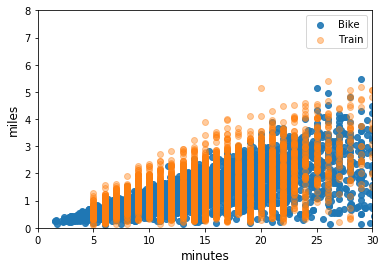

In [177]:
# Visualization
fig = plt.figure()
plt.scatter(x = mainTestOutputDF['bikeMins'],y = mainTestOutputDF['coorDistance'], alpha = 0.9)
plt.scatter(x = mainTestOutputDF['trainMins'],y = mainTestOutputDF['coorDistance'], alpha = 0.4)
# fig.suptitle('Travel Time per Mile', fontsize=20)
plt.xlabel('minutes', fontsize=12)
plt.ylabel('miles', fontsize=12)
plt.legend(["Bike","Train"])
# Remove outliers
plt.xlim(0,30)#minutes
plt.ylim(0,8) #miles

In [35]:
# Calculate the average distance where bike is faster than train
count = 0
bikeFasterCount = 0
for t_id, trip in mainTestOutputDF.iterrows():
    count += 1
    if trip["bikeMins"] < trip["trainMins"]:
        bikeFasterCount += 1
        
print(bikeFasterCount/count)
        

0.46169132258776774


In [36]:
# plt.scatter(x = clean_data2['coorDistance'], y = clean_data2['bikeMins'], alpha = 0.1)
# plt.scatter(x = clean_data2['coorDistance'], y = clean_data2['trainMins'], alpha = 0.1)

In [37]:
#quickestTrainTime = nx.algorithms.shortest_paths.dijkstra_path_length(tubeGraph,oName,dName, weight = "time") + math.floor(nx.algorithms.shortest_paths.dijkstra_path_length(tubeGraph, oName, dName)/3)*3

In [38]:
# Determine which trips were faster riding a bike

# tripsFasterWithBike = 0
# for t_id, trip in mainTestOutputDF.iterrows():
#     if trip['trainMins'] > trip['bikeMins']:
#         tripsFasterWithBike = tripsFasterWithBike + 1
        
# print("There are:", tripsFasterWithBike, "Faster trips with a bike out of", len(mainTestOutputDF) ,"trips.")

In [39]:
#  Get the coordinates of lots of possible bike trips
#  Use this to compile the Uber data.
def computeSetOfCoords():
    setOfCoordinates = {}
    for i in range(0,100):
        (randLat1, randLong1, randLat2, randLong2, oBike, dBike, coorDistance) = getRandomBikeTrip()
        setOfCoordinates[i] = {"randLat1":randLat1, "randLong1":randLong1, "randLat2":randLat2, "randLong2":randLong2, "oBike":oBike, "dBike":dBike, "coorDistance":coorDistance}

    setOfCoordinatesDF = pd.DataFrame.from_dict(setOfCoordinates, orient="index")
    setOfCoordinatesDF.to_csv("../uber/setOfCoordinates.csv")
    
    return setOfCoordinatesDF

#setOfCoordinatesDF

In [69]:
# Fetches equivalant trip data for uber rides by asking the Uber API directly.  
def askUberForInfo():
    
    uberResults = {}
    uberRawResults = {}
    tokens = ["JA.VUNmGAAAAAAAEgASAAAABwAIAAwAAAAAAAAAEgAAAAAAAAG8AAAAFAAAAAAADgAQAAQAAAAIAAwAAAAOAAAAkAAAABwAAAAEAAAAEAAAANtHflT8X6DoYgIpCEVvhHRsAAAA2UI88meKNaFqi1aP8LM1syhGcTLmrN3bvmRGohrWvljT6ALAFnJJKdfgTlqnnl50IsXy1CwvcUQTysW5bpMrhGFKOokiYeaMZpxikirFh12Vyrf9mmLsSL0vfx3wg820TuLjp6GGxAoU6tInDAAAAJDaK7uypaWVZxNPcSQAAABiMGQ4NTgwMy0zOGEwLTQyYjMtODA2ZS03YTRjZjhlMTk2ZWU", 'JA.VUNmGAAAAAAAEgASAAAABwAIAAwAAAAAAAAAEgAAAAAAAAG8AAAAFAAAAAAADgAQAAQAAAAIAAwAAAAOAAAAkAAAABwAAAAEAAAAEAAAAM_yxbT1BPzwSOymOXStGetsAAAAurbsvx8OqXR8FI774FPoE9iTS93TFkHrFEjA_FOAAufTRMemHv0eMmLuSkRvONJBQEX5ESAzxYyq-DZJjxJiCPUXRLRBwSQ_LzYQJN4JURYF7G70x8oGJXOGGof8fAswKOfA7RtKsbaIy-PfDAAAAE0SqVeUlRC5cN9KryQAAABiMGQ4NTgwMy0zOGEwLTQyYjMtODA2ZS03YTRjZjhlMTk2ZWU','JA.VUNmGAAAAAAAEgASAAAABwAIAAwAAAAAAAAAEgAAAAAAAAG8AAAAFAAAAAAADgAQAAQAAAAIAAwAAAAOAAAAkAAAABwAAAAEAAAAEAAAAMswH7vSMNlBOXSNVxsX7BJsAAAACKszwJhNzfFi2nPv1m7aCbCPeTFFG6ntVaw6dAoUnwa47cTsDmK6jpnSh6kVOJXPhGRDVCAZXh-2iHslwDj7_x1FsyhO4nl7S0pxfVN4zFfk7v1-gBsY_-5z9gNZl6jQ70qVXQSy5YLMwvv5DAAAAJ0myYCyXBVu-jv69yQAAABiMGQ4NTgwMy0zOGEwLTQyYjMtODA2ZS03YTRjZjhlMTk2ZWU']
    idx = 0
    
    for token in tokens:
        setOfCoordinatesDF = computeSetOfCoords()
        for e_idx, element in setOfCoordinatesDF.iterrows():
            
            if (element["oBike"] == element["dBike"]):
                continue


            a = element['randLat1']
            b = element['randLong1']
            c = element['randLat2']
            d = element['randLong2']
            
            tokenStr = "Bearer " + token

            data = json.dumps({"start_latitude": a,"start_longitude": b,"end_latitude": c,"end_longitude": d})
            headers = {'Content-Type': 'application/json', 'Authorization': tokenStr}
            r = requests.post('https://api.uber.com/v1.2/requests/estimate', headers=headers, data=data)

            response = r.json()
            print(r.status_code, "for #", idx)

            if (r.status_code != 200):
                print("Encountered Error with API on iteration", idx)
                print(response)
                break

            rawUberTripTime = response["trip"]["duration_estimate"]
            uberTripDistance = response["trip"]["distance_estimate"]
            uberTripValue = response['estimate']['display']
            pickupEstimate = response['pickup_estimate']

            
            
            # Increment Global index
            idx = idx + 1

            uberResults[idx] = {"originBikeStation": int(element["oBike"]), 
                                  "destBikeStation": int(element["dBike"]), 
                                  "rawUberTripTime":rawUberTripTime,
                                  "pickupEstimate": pickupEstimate, 
                                  "uberTripDistance": uberTripDistance, 
                                  "uberTripValue": uberTripValue,
                                  "uberTripTime": rawUberTripTime + (pickupEstimate*60)}

            uberRawResults[idx] = response

        uberResultsDF = pd.DataFrame.from_dict(uberResults, orient="index")
        rawUberResultsDF = pd.DataFrame.from_dict(uberRawResults, orient="index")
        timeStamp = int(time.time())
        uberResultsDF.to_csv("../uber/uberResults" + str(timeStamp) + ".csv")
        rawUberResultsDF.to_csv("../uber/uberRawResults" + str(timeStamp) + ".csv")

    return uberResultsDF, rawUberResultsDF



In [70]:
# RUNS API SCRIPT
# Generate a set of coordinates that is a valid trips on bikes
# Calculate an equivalant trip with Uber by asking Uber's API.  (Gets the price and travel time)

uberResultsDF, rawUberResultsDF = askUberForInfo()



200 for # 0
200 for # 1
200 for # 2
200 for # 3
200 for # 4
200 for # 5
200 for # 6
200 for # 7
200 for # 8
200 for # 9
200 for # 10
200 for # 11
200 for # 12
200 for # 13
200 for # 14
200 for # 15
200 for # 16
200 for # 17
200 for # 18
200 for # 19
200 for # 20
200 for # 21
200 for # 22
200 for # 23
200 for # 24
200 for # 25
200 for # 26
200 for # 27
200 for # 28
200 for # 29
200 for # 30
200 for # 31
200 for # 32
200 for # 33
200 for # 34
200 for # 35
200 for # 36
200 for # 37
200 for # 38
200 for # 39
200 for # 40
200 for # 41
200 for # 42
200 for # 43
200 for # 44
200 for # 45
200 for # 46
200 for # 47
200 for # 48
200 for # 49
200 for # 50
200 for # 51
200 for # 52
200 for # 53
200 for # 54
200 for # 55
200 for # 56
200 for # 57
200 for # 58
200 for # 59
200 for # 60
200 for # 61
200 for # 62
200 for # 63
200 for # 64
200 for # 65
200 for # 66
200 for # 67
200 for # 68
200 for # 69
200 for # 70
200 for # 71
200 for # 72
200 for # 73
200 for # 74
200 for # 75
200 for # 76
200 for #

In [42]:
########## MAIN EXPERIMENT WITH UBER #######
# Iterates through uber trip data, 
# using the stored origin station and destination to calculate bike and train trips.

mainTestOutputWithUber = {}


for u_id, uberTrip in uberTripData.iterrows(): ### RUNNING ON A PRE-MADE DATASET LOADED IN THE BEGINNING
    print("[!] Iteration", u_id)

    # (randLat1, randLong1, randLat2, randLong2, oBike, dBike, coorDistance) = getRandomBikeTrip()
    oBike = uberTrip['originBikeStation']
    dBike = uberTrip['destBikeStation']
    
    uberTripTime = uberTrip['uberTripTime']
    uberTripDistance = uberTrip['uberTripDistance']
    uberTripValue = uberTrip['uberTripValue']
    
    originLat  =  bikeDockingStations.at[oBike, "station__lat"]
    originLong =  bikeDockingStations.at[oBike, "station__long"]
    destLat  =    bikeDockingStations.at[dBike, "station__lat"]
    destLong =    bikeDockingStations.at[dBike, "station__long"]
    
    # Calculate the nearest origin and destination stations, given the random coordinates.
    (oTrain,dTrain) = closestTubeStation(originLat, originLong, destLat, destLong)

    # Calculate the minimum/average travel time (with our data) given an origin and a destination.
    trainMins = calcTrainTravelTimeMins(oTrain,dTrain)
    bikeMins = calcBikeTravelTimeMins(oBike, dBike)

    if bikeMins == -1 or trainMins == -1 or (oTrain == dTrain):
        print("Skipping this one...")
        continue
    
    uberMins = 0
    if uberTripTime > 0:
        uberMins = uberTripTime / 60    
        
    mainTestOutputWithUber[u_id] = {
        "oLat": originLat,
        "oLong": originLong,
        "dLat": destLat,
        "dLong": destLong,
        "uberTripDistance": uberTripDistance,
        "uberTripValue": uberTripValue,
        "oTrain": oTrain, 
        "dTrain": dTrain,
        "oBike": oBike,
        "dBike": dBike,
        "bikeMins": bikeMins,
        "trainMins": trainMins,
        "uberMins": uberMins}
    
mainTestOutputWithUberDF = pd.DataFrame.from_dict(mainTestOutputWithUber, orient="index")

[!] Iteration 0
Nearest train station to Random Origin: Tottenham Court Road 51.5165 -0.131
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  10 minutes.
88 44246 44838
For bikes there were: 47 exact matches.
The average time of this BIKE trip is: 8.23404255319149 minutes.
[!] Iteration 1
Nearest train station to Random Origin: Tower Gateway 51.5106 -0.0743
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  14 minutes.
46 24042 24809
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 7.25 minutes.
[!] Iteration 2
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  18 minutes.
169 84333 84903
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 6.6 minutes.
[!] Itera

For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 9.733333333333333 minutes.
[!] Iteration 26
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  16 minutes.
14 5428 8543
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 16.25 minutes.
[!] Iteration 27
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN trip is  19 minutes.
372 173953 174333
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 13.333333333333334 minutes.
[!] Iteration 28
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  16 minutes.
36

Nearest train station to Random Origin: Warren Street 51.5247 -0.1384
Nearest train station to Random Destination: Bond Street 51.5142 -0.1494
The quickest time for this TRAIN trip is  11 minutes.
98 48483 49028
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 9.2 minutes.
[!] Iteration 52
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  5 minutes.
755 290132 290666
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 4.5 minutes.
[!] Iteration 53
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  20 minutes.
288 140184 140757
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 25.2 minutes.
[!] Iteration 54
Nearest train station to Random O

Nearest train station to Random Origin: Lambeth North 51.4991 -0.1115
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  26 minutes.
117 60399 60759
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 21.5 minutes.
[!] Iteration 78
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  15 minutes.
55 28212 29513
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 13.2 minutes.
[!] Iteration 79
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  20 minutes.
191 92980 94943
For bikes there were: 118 exact matches.
The average time of this BIKE trip is: 28.10169491525424 minutes.
[!] Iteration 80
Nearest train station 

[!] Iteration 102
Nearest train station to Random Origin: Euston 51.5282 -0.1337
Nearest train station to Random Destination: Euston Square 51.526 -0.1359
The quickest time for this TRAIN trip is  12 minutes.
214 106452 107097
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 2.1666666666666665 minutes.
[!] Iteration 103
Nearest train station to Random Origin: Lancaster Gate 51.5119 -0.1756
Nearest train station to Random Destination: Shepherd's Bush (C) 51.5046 -0.2187
The quickest time for this TRAIN trip is  10 minutes.
248 122695 124216
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 104
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  6 minutes.
215 107098 108057
For bikes there were: 14 exact matches.
The average time of this BIKE trip is: 9.214285714285715 minutes.
[!]

Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  11 minutes.
731 283018 283296
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 130
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  9 minutes.
70 35624 35821
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 7.5 minutes.
[!] Iteration 131
Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  18 minutes.
726 281521 281777
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 13.666666666666666 minutes.
[!] Iteration 132
Ne

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Charing Cross 51.508 -0.1247
The quickest time for this TRAIN trip is  18 minutes.
574 237025 237996
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 24.333333333333332 minutes.
[!] Iteration 158
Nearest train station to Random Origin: Mornington Crescent 51.5342 -0.1387
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  8 minutes.
362 171499 171830
For bikes there were: 22 exact matches.
The average time of this BIKE trip is: 3.4090909090909087 minutes.
[!] Iteration 159
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Aldgate 51.5143 -0.0755
The quickest time for this TRAIN trip is  17 minutes.
358 168842 169271
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 16.666666666666668 minut

Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  15 minutes.
242 120334 120717
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 14.5 minutes.
[!] Iteration 184
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Notting Hill Gate 51.5094 -0.1967
The quickest time for this TRAIN trip is  21 minutes.
213 105171 106451
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 54.8 minutes.
[!] Iteration 185
Nearest train station to Random Origin: Tower Hill 51.5098 -0.0766
Nearest train station to Random Destination: Tower Gateway 51.5106 -0.0743
The quickest time for this TRAIN trip is  15 minutes.
130 65421 66148
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 11.333333333333334 minutes.
[!] Iteration 186
Nearest train station to Random Origin: Bow Road 51.5269 -0.0

For bikes there were: 19 exact matches.
The average time of this BIKE trip is: 11.631578947368421 minutes.
[!] Iteration 215
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  15 minutes.
84 42626 42955
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 216
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  20 minutes.
191 92980 94943
For bikes there were: 98 exact matches.
The average time of this BIKE trip is: 38.66326530612245 minutes.
[!] Iteration 217
Nearest train station to Random Origin: Kensington (Olympia) 51.4983 -0.2106
Nearest train station to Random Destination: Shepherd's Bush (C) 51.5046 -0.2187
The quickest time for this TRAIN trip is  19 minutes.

For bikes there were: 31 exact matches.
The average time of this BIKE trip is: 4.129032258064516 minutes.
[!] Iteration 240
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  0 minutes.
702 274216 274609
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 5.1818181818181825 minutes.
Skipping this one...
[!] Iteration 241
Nearest train station to Random Origin: Earl's Court 51.492 -0.1973
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  7 minutes.
296 143523 143848
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 5.0 minutes.
[!] Iteration 242
Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip i

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Moorgate 51.5186 -0.0886
The quickest time for this TRAIN trip is  5 minutes.
574 237025 237996
For bikes there were: 14 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 268
Nearest train station to Random Origin: Temple 51.5111 -0.1141
Nearest train station to Random Destination: Borough 51.5011 -0.0943
The quickest time for this TRAIN trip is  18 minutes.
174 86115 86648
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 14.714285714285715 minutes.
[!] Iteration 269
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  7 minutes.
360 169565 170266
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 4.5 minutes.
[!] Iteration 270
Nearest train station to Random Origin: Ov

Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  7 minutes.
67 34181 34717
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 17.5 minutes.
[!] Iteration 296
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  0 minutes.
85 42956 43518
For bikes there were: 27 exact matches.
The average time of this BIKE trip is: 10.518518518518517 minutes.
Skipping this one...
[!] Iteration 297
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Queensway 51.5107 -0.1877
The quickest time for this TRAIN trip is  17 minutes.
350 165129 165948
For bikes there were: 63 exact matches.
The average time of this BIKE trip is: 36.55555555555556 

The quickest time for this TRAIN trip is  21 minutes.
553 230653 231807
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 4.571428571428571 minutes.
[!] Iteration 322
Nearest train station to Random Origin: Bond Street 51.5142 -0.1494
Nearest train station to Random Destination: Clapham Common 51.4618 -0.1384
The quickest time for this TRAIN trip is  26 minutes.
366 172853 173073
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 19.75 minutes.
[!] Iteration 323
Nearest train station to Random Origin: Whitechapel 51.5194 -0.0612
Nearest train station to Random Destination: Aldgate East 51.5154 -0.0726
The quickest time for this TRAIN trip is  6 minutes.
500 214657 215131
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 5.166666666666667 minutes.
[!] Iteration 324
Nearest train station to Random Origin: Liverpool Street 51.5178 -0.0823
Nearest train station to Random Destination: Old Street 51.5263 -0.08

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 11.0 minutes.
[!] Iteration 348
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  17 minutes.
420 190468 190739
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 20.88888888888889 minutes.
[!] Iteration 349
Nearest train station to Random Origin: Tower Hill 51.5098 -0.0766
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  10 minutes.
298 143964 144628
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 20.23076923076923 minutes.
[!] Iteration 350
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  8 minutes.
428 193843 1

Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  15 minutes.
628 253397 253661
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 26.0 minutes.
[!] Iteration 375
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  7 minutes.
268 131596 132195
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 4.2 minutes.
[!] Iteration 376
Nearest train station to Random Origin: Oxford Circus 51.515 -0.1415
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  16 minutes.
116 59622 60398
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 54.71428571428571 minutes.
[!] Iteration 377
Nearest train stati

Nearest train station to Random Origin: Hammersmith 51.4936 -0.2251
Nearest train station to Random Destination: Kensington (Olympia) 51.4983 -0.2106
The quickest time for this TRAIN trip is  10 minutes.
730 282653 283017
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 10.428571428571427 minutes.
[!] Iteration 400
Nearest train station to Random Origin: Shepherd's Bush (C) 51.5046 -0.2187
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  15 minutes.
647 258903 259226
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 19.5 minutes.
[!] Iteration 401
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  10 minutes.
193 95600 96367
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 45.6 minutes.
[!] Iterat

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 6.5 minutes.
[!] Iteration 431
Nearest train station to Random Origin: St. Paul's 51.5146 -0.0973
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  16 minutes.
48 25299 26103
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 432
Nearest train station to Random Origin: Bow Church 51.5273 -0.0208
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  26 minutes.
495 213390 213680
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 67.5 minutes.
[!] Iteration 433
Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Whitechapel 51.5194 -0.0612
The quickest time for this TRAIN trip is  16 minutes.
263 129393 129845
For bikes there were: 4 exact matches.
The 

Nearest train station to Random Destination: St. James's Park 51.4994 -0.1335
The quickest time for this TRAIN trip is  13 minutes.
9 3006 3465
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 464
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  9 minutes.
733 284520 284858
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 11.75 minutes.
[!] Iteration 465
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  6 minutes.
240 120152 120332
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 10.2 minutes.
[!] Iteration 466
Nearest train station to Random Origin: St. Paul's 51.5146 -0.0973
Nearest train

For bikes there were: 45 exact matches.
The average time of this BIKE trip is: 4.222222222222222 minutes.
Skipping this one...
[!] Iteration 492
Nearest train station to Random Origin: Whitechapel 51.5194 -0.0612
Nearest train station to Random Destination: All Saints 51.5107 -0.013000000000000001
The quickest time for this TRAIN trip is  18 minutes.
500 214657 215131
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 14.5 minutes.
[!] Iteration 493
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  7 minutes.
264 129846 130447
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.5 minutes.
[!] Iteration 494
Nearest train station to Random Origin: Green Park 51.5067 -0.1428
Nearest train station to Random Destination: Marylebone 51.5225 -0.1631
The quickest time for this TRAIN trip is  13 minutes.
382 179258 

The average time of this BIKE trip is: 26.0 minutes.
[!] Iteration 522
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  5 minutes.
218 109857 110287
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 10.25 minutes.
[!] Iteration 523
Nearest train station to Random Origin: Great Portland Street 51.5238 -0.1439
Nearest train station to Random Destination: Baker Street 51.5226 -0.1571
The quickest time for this TRAIN trip is  7 minutes.
81 41305 41821
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 5.2857142857142865 minutes.
[!] Iteration 524
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  13 minutes.
673 265877 266063
For bikes there were: 5 exact mat

Nearest train station to Random Origin: Great Portland Street 51.5238 -0.1439
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  15 minutes.
28 15415 15957
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 5.0 minutes.
[!] Iteration 552
Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: Picadilly Circus 51.5098 -0.1342
The quickest time for this TRAIN trip is  13 minutes.
549 229523 229767
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 39.5 minutes.
[!] Iteration 553
Nearest train station to Random Origin: Clapham South 51.4527 -0.14800000000000002
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  29 minutes.
638 255800 256467
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 13.4 minutes.
[!] Iteratio

Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  26 minutes.
737 285524 286322
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iteration 583
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  17 minutes.
14 5428 8543
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 22.666666666666668 minutes.
[!] Iteration 584
Nearest train station to Random Origin: Tower Hill 51.5098 -0.0766
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  15 minutes.
104 52009 53266
For bikes there were: 20 exact matches.
The average time of this BIKE trip is: 40.85 minutes.
[!] Iteration 585
Nearest tr

213 105171 106451
For bikes there were: 25 exact matches.
The average time of this BIKE trip is: 57.080000000000005 minutes.
[!] Iteration 613
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  32 minutes.
615 249415 249771
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 43.25 minutes.
[!] Iteration 614
Nearest train station to Random Origin: Paddington 51.5154 -0.1755
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  16 minutes.
290 140957 141740
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 73.4 minutes.
[!] Iteration 615
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Shoreditch 51.5227 -0.0708
The quickest time for this TRAIN trip is  21 minutes.
446 199

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 648
Nearest train station to Random Origin: Wapping 51.5043 -0.0558
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  17 minutes.
458 203322 203740
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 14.916666666666666 minutes.
[!] Iteration 649
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  15 minutes.
194 96368 97851
For bikes there were: 19 exact matches.
The average time of this BIKE trip is: 8.631578947368421 minutes.
[!] Iteration 650
Nearest train station to Random Origin: Baker Street 51.5226 -0.1571
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  16 minutes.
56 29514 29840
For

For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 5.0 minutes.
[!] Iteration 673
Nearest train station to Random Origin: South Kensington 51.4941 -0.1738
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  0 minutes.
218 109857 110287
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 2.4 minutes.
Skipping this one...
[!] Iteration 674
Nearest train station to Random Origin: Leicester Square 51.5113 -0.1281
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  10 minutes.
383 179443 179939
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 12.857142857142858 minutes.
[!] Iteration 675
Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN 

The quickest time for this TRAIN trip is  20 minutes.
315 151790 152092
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 39.44444444444444 minutes.
[!] Iteration 702
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  14 minutes.
254 126927 127482
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 703
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  15 minutes.
66 33223 34180
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 16.666666666666668 minutes.
[!] Iteration 704
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for t

For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 734
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Oxford Circus 51.515 -0.1415
The quickest time for this TRAIN trip is  19 minutes.
133 67757 68495
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 23.0 minutes.
[!] Iteration 735
Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  35 minutes.
609 247656 247847
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 17.5 minutes.
[!] Iteration 736
Nearest train station to Random Origin: Marble Arch 51.5136 -0.1586
Nearest train station to Random Destination: Oval 51.4819 -0.113
The quickest time for this TRAIN trip is  23 minutes.
138 70025 70577
For bikes there were: 1 ex

Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  9 minutes.
26 14494 14847
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 9.11111111111111 minutes.
[!] Iteration 763
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  17 minutes.
380 178618 178844
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.5 minutes.
[!] Iteration 764
Nearest train station to Random Origin: West Brompton 51.4872 -0.1953
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  7 minutes.
782 298325 298652
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 765
N

Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  19 minutes.
421 190740 191378
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 14.833333333333334 minutes.
[!] Iteration 793
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Charing Cross 51.508 -0.1247
The quickest time for this TRAIN trip is  14 minutes.
67 34181 34717
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 794
Nearest train station to Random Origin: Oxford Circus 51.515 -0.1415
Nearest train station to Random Destination: Holland Park 51.5075 -0.20600000000000002
The quickest time for this TRAIN trip is  14 minutes.
159 80215 80922
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 24.0 minutes.
[!] Iteration 795
N

Nearest train station to Random Origin: Farringdon 51.5203 -0.1053
Nearest train station to Random Destination: Elephant & Castle 51.4943 -0.1001
The quickest time for this TRAIN trip is  19 minutes.
393 182577 183150
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 824
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  8 minutes.
2 284 750
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 825
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Lambeth North 51.4991 -0.1115
The quickest time for this TRAIN trip is  25 minutes.
126 63698 64358
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 14.5 minutes.
[!] Iteration 826
Nearest train station to

For bikes there were: 98 exact matches.
The average time of this BIKE trip is: 37.47959183673469 minutes.
[!] Iteration 859
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  25 minutes.
203 102143 102877
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 860
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  6 minutes.
723 280748 281215
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 12.666666666666666 minutes.
[!] Iteration 861
Nearest train station to Random Origin: Westferry 51.5097 -0.0265
Nearest train station to Random Destination: Tower Hill 51.5098 -0.0766
The quickest time for this TRAIN trip is  17 minutes.
469 206644 206809
For bikes

Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  9 minutes.
384 179940 180104
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 892
Nearest train station to Random Origin: London Bridge 51.5052 -0.0864
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  0 minutes.
321 153689 154405
For bikes there were: 25 exact matches.
The average time of this BIKE trip is: 8.44 minutes.
Skipping this one...
[!] Iteration 893
Nearest train station to Random Origin: Latimer Road 51.5139 -0.2172
Nearest train station to Random Destination: Shepherd's Bush (C) 51.5046 -0.2187
The quickest time for this TRAIN trip is  25 minutes.
652 260186 260303
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 5.3333333333333

Nearest train station to Random Origin: Sloane Square 51.4924 -0.1565
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  13 minutes.
756 290667 291025
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 924
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  19 minutes.
39 20040 21076
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 12.285714285714285 minutes.
[!] Iteration 925
Nearest train station to Random Origin: West Brompton 51.4872 -0.1953
Nearest train station to Random Destination: Gloucester Road 51.4945 -0.1829
The quickest time for this TRAIN trip is  9 minutes.
782 298325 298652
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 12.222222222222223 minutes.
[!] Iteration 926
Nearest

For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 968
Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Tower Gateway 51.5106 -0.0743
The quickest time for this TRAIN trip is  6 minutes.
489 211609 212100
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 4.25 minutes.
[!] Iteration 969
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  18 minutes.
361 170267 171498
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 970
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Mansion House 51.5122 -0.094
The quickest time for this TRAIN trip is  19 minutes.
246 121693 122448
For bikes there were: 26 exa

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 28.0 minutes.
[!] Iteration 997
Nearest train station to Random Origin: Embankment 51.5074 -0.1223
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  18 minutes.
229 115183 116065
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 21.666666666666668 minutes.
[!] Iteration 998
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Euston Square 51.526 -0.1359
The quickest time for this TRAIN trip is  12 minutes.
93 45968 46350
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
[!] Iteration 999
Nearest train station to Random Origin: Russell Square 51.523 -0.1244
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  6 minutes.
57 29841 30359
For bikes there wer

Nearest train station to Random Origin: Shadwell 51.5117 -0.055999999999999994
Nearest train station to Random Destination: Devons Road 51.5223 -0.0173
The quickest time for this TRAIN trip is  14 minutes.
511 218140 218541
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 17.5 minutes.
[!] Iteration 1030
Nearest train station to Random Origin: West Kensington 51.4907 -0.2065
Nearest train station to Random Destination: Ravenscourt Park 51.4942 -0.2359
The quickest time for this TRAIN trip is  9 minutes.
626 252811 253272
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 16.285714285714285 minutes.
[!] Iteration 1031
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Marylebone 51.5225 -0.1631
The quickest time for this TRAIN trip is  16 minutes.
154 75813 78609
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 1032
N

222 111509 111954
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 1058
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: Marylebone 51.5225 -0.1631
The quickest time for this TRAIN trip is  24 minutes.
113 58208 58446
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 1059
Nearest train station to Random Origin: Notting Hill Gate 51.5094 -0.1967
Nearest train station to Random Destination: Westbourne Park 51.521 -0.2011
The quickest time for this TRAIN trip is  15 minutes.
225 112770 113560
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 10.181818181818182 minutes.
[!] Iteration 1060
Nearest train station to Random Origin: Notting Hill Gate 51.5094 -0.1967
Nearest train station to Random Destination: Shepherd's Bush (H) 51.5058 -0.2265
The quickest time for this TRAIN trip is  2

Nearest train station to Random Origin: Mansion House 51.5122 -0.094
Nearest train station to Random Destination: Covent Garden 51.5129 -0.1243
The quickest time for this TRAIN trip is  21 minutes.
136 69414 70023
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.5 minutes.
[!] Iteration 1088
Nearest train station to Random Origin: Leicester Square 51.5113 -0.1281
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  6 minutes.
386 180106 180580
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 1089
Nearest train station to Random Origin: Leicester Square 51.5113 -0.1281
Nearest train station to Random Destination: Warwick Avenue 51.5235 -0.1835
The quickest time for this TRAIN trip is  24 minutes.
325 155296 155596
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 51.0 minutes.
[!] Iteration 1090
Nearest train 

Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  5 minutes.
203 102143 102877
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 1115
Nearest train station to Random Origin: Mornington Crescent 51.5342 -0.1387
Nearest train station to Random Destination: Temple 51.5111 -0.1141
The quickest time for this TRAIN trip is  20 minutes.
131 66149 66415
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 12.6 minutes.
[!] Iteration 1116
Nearest train station to Random Origin: St. John's Wood 51.5347 -0.174
Nearest train station to Random Destination: Warren Street 51.5247 -0.1384
The quickest time for this TRAIN trip is  20 minutes.
247 122449 122694
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 16.6 minutes.
[!] Iteration 1117
Nearest train station to Ran

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 13.25 minutes.
[!] Iteration 1146
Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  6 minutes.
531 223113 223512
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 22.933333333333334 minutes.
[!] Iteration 1147
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  20 minutes.
536 225021 225277
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 10.0 minutes.
[!] Iteration 1148
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  7 minutes.
320 153129 153688
For bikes there were: 24 ex

For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 10.857142857142858 minutes.
[!] Iteration 1180
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  11 minutes.
129 64979 65420
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 16.714285714285715 minutes.
[!] Iteration 1181
Nearest train station to Random Origin: Tower Hill 51.5098 -0.0766
Nearest train station to Random Destination: Aldgate 51.5143 -0.0755
The quickest time for this TRAIN trip is  8 minutes.
298 143964 144628
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 8.5 minutes.
[!] Iteration 1182
Nearest train station to Random Origin: Liverpool Street 51.5178 -0.0823
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  15 minutes.
217 108489 109856
For

For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 73.4 minutes.
[!] Iteration 1211
Nearest train station to Random Origin: Knightsbridge 51.5015 -0.1607
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  7 minutes.
166 83001 83361
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 12.5 minutes.
[!] Iteration 1212
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  7 minutes.
695 271479 272327
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 8.571428571428573 minutes.
[!] Iteration 1213
Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  16 minutes.
67 34181 34717
For bikes there were:

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 1240
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: West Kensington 51.4907 -0.2065
The quickest time for this TRAIN trip is  10 minutes.
596 244511 244978
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 1241
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  15 minutes.
446 199537 200055
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 11.333333333333334 minutes.
[!] Iteration 1242
Nearest train station to Random Origin: Pudding Mill Lane 51.5343 -0.0139
Nearest train station to Random Destination: Russell Square 51.523 -0.1244
The quickest time for this TRAIN trip is  32 minutes.
692 270

Nearest train station to Random Origin: Stepney Green 51.5221 -0.047
Nearest train station to Random Destination: Stepney Green 51.5221 -0.047
The quickest time for this TRAIN trip is  0 minutes.
478 207795 208353
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 30.857142857142854 minutes.
Skipping this one...
[!] Iteration 1275
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Charing Cross 51.508 -0.1247
The quickest time for this TRAIN trip is  13 minutes.
14 5428 8543
For bikes there were: 37 exact matches.
The average time of this BIKE trip is: 16.756756756756758 minutes.
[!] Iteration 1276
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  0 minutes.
32 17251 18120
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 10.0 mi

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 25.0 minutes.
[!] Iteration 1301
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  14 minutes.
317 152094 152240
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 24.0 minutes.
[!] Iteration 1302
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: King's Cross St. Pancras 51.5308 -0.1238
The quickest time for this TRAIN trip is  8 minutes.
162 81763 82190
For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 10.117647058823529 minutes.
[!] Iteration 1303
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  9 minutes.
806 306802 

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 1327
Nearest train station to Random Origin: Aldgate 51.5143 -0.0755
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  15 minutes.
779 297139 297501
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 1328
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  8 minutes.
320 153129 153688
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 10.5 minutes.
[!] Iteration 1329
Nearest train station to Random Origin: Hyde Park Corner 51.5027 -0.1527
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  17 minutes.
191 92980 94943
For bikes there were: 103 exact matches

Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  7 minutes.
574 237025 237996
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 7.0 minutes.
[!] Iteration 1359
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  6 minutes.
746 287800 288011
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 12.0 minutes.
[!] Iteration 1360
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  17 minutes.
2 284 750
For bikes there were: 11 exact matches.
The average time of this BIKE trip is: 52.90909090909091 minutes.
[!] Iteration 1361
Nearest train station to Random Origin: Vauxhall 51.4861 -0.1253
Nearest train stat

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 6.0 minutes.
[!] Iteration 1393
Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Euston Square 51.526 -0.1359
The quickest time for this TRAIN trip is  14 minutes.
283 139178 139320
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 12.4 minutes.
[!] Iteration 1394
Nearest train station to Random Origin: Tottenham Court Road 51.5165 -0.131
Nearest train station to Random Destination: Tottenham Court Road 51.5165 -0.131
The quickest time for this TRAIN trip is  0 minutes.
15 8544 9036
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 18.333333333333332 minutes.
Skipping this one...
[!] Iteration 1395
Nearest train station to Random Origin: Marylebone 51.5225 -0.1631
Nearest train station to Random Destination: Shepherd's Bush (C) 51.5046 -0.2187
The quickest time for this TRAIN trip is  24 minutes.


Nearest train station to Random Origin: Elephant & Castle 51.4943 -0.1001
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  7 minutes.
549 229523 229767
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 10.75 minutes.
[!] Iteration 1422
Nearest train station to Random Origin: Barbican 51.5204 -0.0979
Nearest train station to Random Destination: Southwark 51.501000000000005 -0.1052
The quickest time for this TRAIN trip is  21 minutes.
107 53876 54837
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 13.25 minutes.
[!] Iteration 1423
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  18 minutes.
614 249242 249414
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 19.0 minutes.
[!] Iteration 1424
Nearest train station 

The average time of this BIKE trip is: 11.333333333333334 minutes.
[!] Iteration 1449
Nearest train station to Random Origin: Lancaster Gate 51.5119 -0.1756
Nearest train station to Random Destination: Lancaster Gate 51.5119 -0.1756
The quickest time for this TRAIN trip is  0 minutes.
248 122695 124216
For bikes there were: 32 exact matches.
The average time of this BIKE trip is: 23.875 minutes.
Skipping this one...
[!] Iteration 1450
Nearest train station to Random Origin: Westminster 51.501000000000005 -0.1254
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  8 minutes.
387 180581 181065
For bikes there were: 15 exact matches.
The average time of this BIKE trip is: 8.2 minutes.
[!] Iteration 1451
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  7 minutes.
326 155597 156269
For bikes there were: 1 e

For bikes there were: 17 exact matches.
The average time of this BIKE trip is: 9.176470588235295 minutes.
[!] Iteration 1484
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  11 minutes.
731 283018 283296
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 8.666666666666666 minutes.
[!] Iteration 1485
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  11 minutes.
618 250195 250490
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 18.0 minutes.
[!] Iteration 1486
Nearest train station to Random Origin: Westbourne Park 51.521 -0.2011
Nearest train station to Random Destination: Royal Oak 51.519 -0.188
The quickest time for this TRAIN trip is  6 minutes.
661 2

Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Oval 51.4819 -0.113
The quickest time for this TRAIN trip is  18 minutes.
320 153129 153688
For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 10.125 minutes.
[!] Iteration 1511
Nearest train station to Random Origin: Bethnal Green 51.527 -0.0549
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  17 minutes.
501 215132 215452
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 10.6 minutes.
[!] Iteration 1512
Nearest train station to Random Origin: Goodge Street 51.5205 -0.1347
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  11 minutes.
12 4156 5104
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 5.2 minutes.
[!] Iteration 1513
Nearest train station to Random Origin: Russell

The quickest time for this TRAIN trip is  19 minutes.
169 84333 84903
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 10.333333333333334 minutes.
[!] Iteration 1540
Nearest train station to Random Origin: Warwick Avenue 51.5235 -0.1835
Nearest train station to Random Destination: Warwick Avenue 51.5235 -0.1835
The quickest time for this TRAIN trip is  0 minutes.
255 127483 127847
For bikes there were: 18 exact matches.
The average time of this BIKE trip is: 3.555555555555556 minutes.
Skipping this one...
[!] Iteration 1541
Nearest train station to Random Origin: Barons Court 51.4905 -0.2139
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  10 minutes.
761 292062 292323
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 4.0 minutes.
[!] Iteration 1542
Nearest train station to Random Origin: Barons Court 51.4905 -0.2139
Nearest train station to Random Destination: 

Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Monument 51.5108 -0.0863
The quickest time for this TRAIN trip is  12 minutes.
326 155597 156269
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 15.333333333333334 minutes.
[!] Iteration 1566
Nearest train station to Random Origin: Ravenscourt Park 51.4942 -0.2359
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  31 minutes.
668 264601 264849
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 87.0 minutes.
[!] Iteration 1567
Nearest train station to Random Origin: Notting Hill Gate 51.5094 -0.1967
Nearest train station to Random Destination: Notting Hill Gate 51.5094 -0.1967
The quickest time for this TRAIN trip is  0 minutes.
212 104994 105170
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 25.8 minutes.
Skipping this one...
[!]

Nearest train station to Random Origin: Monument 51.5108 -0.0863
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  7 minutes.
199 99548 100476
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 10.7 minutes.
[!] Iteration 1597
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Chancery Lane 51.5185 -0.1111
The quickest time for this TRAIN trip is  20 minutes.
421 190740 191378
For bikes there were: 13 exact matches.
The average time of this BIKE trip is: 8.923076923076923 minutes.
[!] Iteration 1598
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Liverpool Street 51.5178 -0.0823
The quickest time for this TRAIN trip is  14 minutes.
75 39167 39623
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 9.0 minutes.
[!] Iteration 1599
N

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 15.0 minutes.
[!] Iteration 1626
Nearest train station to Random Origin: Knightsbridge 51.5015 -0.1607
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  16 minutes.
303 146167 147599
For bikes there were: 14 exact matches.
The average time of this BIKE trip is: 20.07142857142857 minutes.
[!] Iteration 1627
Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Blackfriars 51.512 -0.1031
The quickest time for this TRAIN trip is  14 minutes.
320 153129 153688
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 17.0 minutes.
[!] Iteration 1628
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Waterloo 51.5036 -0.1143
The quickest time for this TRAIN trip is  16 minutes.
797 303492 30

For bikes there were: 8 exact matches.
The average time of this BIKE trip is: 96.25 minutes.
Skipping this one...
[!] Iteration 1651
Nearest train station to Random Origin: Bromley-By-Bow 51.5248 -0.0119
Nearest train station to Random Destination: Stepney Green 51.5221 -0.047
The quickest time for this TRAIN trip is  9 minutes.
484 210054 210129
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 1652
Nearest train station to Random Origin: Westbourne Park 51.521 -0.2011
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  28 minutes.
661 262295 262840
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 29.4 minutes.
[!] Iteration 1653
Nearest train station to Random Origin: Clapham South 51.4527 -0.14800000000000002
Nearest train station to Random Destination: Hyde Park Corner 51.5027 -0.1527
The quickest time for this TRAIN trip is  28 min

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 54.0 minutes.
[!] Iteration 1679
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  7 minutes.
204 102878 103185
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 11.5 minutes.
[!] Iteration 1680
Nearest train station to Random Origin: Clapham Common 51.4618 -0.1384
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  14 minutes.
640 256825 257113
For bikes there were: 9 exact matches.
The average time of this BIKE trip is: 11.444444444444445 minutes.
[!] Iteration 1681
Nearest train station to Random Origin: Westbourne Park 51.521 -0.2011
Nearest train station to Random Destination: Shepherd's Bush (H) 51.5058 -0.2265
The quickest time for this TRAIN trip is  9 minutes.
758 291402 291688
For bikes th

Nearest train station to Random Origin: Clapham South 51.4527 -0.14800000000000002
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  35 minutes.
638 255800 256467
For bikes there were: 26 exact matches.
The average time of this BIKE trip is: 3.423076923076923 minutes.
[!] Iteration 1712
Nearest train station to Random Origin: Marylebone 51.5225 -0.1631
Nearest train station to Random Destination: Parsons Green 51.4753 -0.2011
The quickest time for this TRAIN trip is  28 minutes.
201 100846 101244
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 34.0 minutes.
[!] Iteration 1713
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Aldgate 51.5143 -0.0755
The quickest time for this TRAIN trip is  13 minutes.
539 225740 226169
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 10.2 minutes.
[!] Iteration 1714

Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Monument 51.5108 -0.0863
The quickest time for this TRAIN trip is  9 minutes.
361 170267 171498
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 14.083333333333334 minutes.
[!] Iteration 1742
Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Sloane Square 51.4924 -0.1565
The quickest time for this TRAIN trip is  17 minutes.
233 117099 117660
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 14.0 minutes.
[!] Iteration 1743
Nearest train station to Random Origin: Borough 51.5011 -0.0943
Nearest train station to Random Destination: London Bridge 51.5052 -0.0864
The quickest time for this TRAIN trip is  6 minutes.
801 305201 305679
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 14.75 minutes.
[!] Iteration 1744
Nearest train s

Nearest train station to Random Origin: Victoria 51.4965 -0.1447
Nearest train station to Random Destination: Vauxhall 51.4861 -0.1253
The quickest time for this TRAIN trip is  8 minutes.
360 169565 170266
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 13.5 minutes.
[!] Iteration 1774
Nearest train station to Random Origin: Aldgate East 51.5154 -0.0726
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  18 minutes.
506 216255 216646
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 18.2 minutes.
[!] Iteration 1775
Nearest train station to Random Origin: Moorgate 51.5186 -0.0886
Nearest train station to Random Destination: Baker Street 51.5226 -0.1571
The quickest time for this TRAIN trip is  18 minutes.
3 751 1321
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iteration 1776
Nearest train station to Random Origin: Shoreditc

Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: High Street Kensington 51.5009 -0.1925
The quickest time for this TRAIN trip is  8 minutes.
405 187786 188534
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 9.166666666666666 minutes.
[!] Iteration 1800
Nearest train station to Random Origin: Lancaster Gate 51.5119 -0.1756
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  19 minutes.
248 122695 124216
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 38.5 minutes.
[!] Iteration 1801
Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Angel 51.5322 -0.1058
The quickest time for this TRAIN trip is  22 minutes.
531 223113 223512
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 24.0 minutes.
[!] Iteration 1802
Ne

For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 16.0 minutes.
[!] Iteration 1827
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Shadwell 51.5117 -0.055999999999999994
The quickest time for this TRAIN trip is  14 minutes.
39 20040 21076
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 14.8 minutes.
[!] Iteration 1828
Nearest train station to Random Origin: East Putney 51.4586 -0.2112
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  11 minutes.
694 271305 271478
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 16.666666666666668 minutes.
[!] Iteration 1829
Nearest train station to Random Origin: Gloucester Road 51.4945 -0.1829
Nearest train station to Random Destination: West Brompton 51.4872 -0.1953
The quickest time for this TRAIN trip is  9 minutes.
266 130850 131279

Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  0 minutes.
32 17251 18120
For bikes there were: 12 exact matches.
The average time of this BIKE trip is: 10.5 minutes.
Skipping this one...
[!] Iteration 1854
Nearest train station to Random Origin: High Street Kensington 51.5009 -0.1925
Nearest train station to Random Destination: Knightsbridge 51.5015 -0.1607
The quickest time for this TRAIN trip is  16 minutes.
404 186798 187785
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 31.25 minutes.
[!] Iteration 1855
Nearest train station to Random Origin: Pimlico 51.4893 -0.1334
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  0 minutes.
291 141741 141987
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 5.666666666666667 minutes.
Skipping this

For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 16.2 minutes.
[!] Iteration 1886
Nearest train station to Random Origin: Barons Court 51.4905 -0.2139
Nearest train station to Random Destination: West Kensington 51.4907 -0.2065
The quickest time for this TRAIN trip is  6 minutes.
711 277030 277295
For bikes there were: 10 exact matches.
The average time of this BIKE trip is: 8.5 minutes.
[!] Iteration 1887
Nearest train station to Random Origin: Fulham Broadway 51.4804 -0.195
Nearest train station to Random Destination: South Kensington 51.4941 -0.1738
The quickest time for this TRAIN trip is  11 minutes.
737 285524 286322
For bikes there were: 2 exact matches.
The average time of this BIKE trip is: 12.5 minutes.
[!] Iteration 1888
Nearest train station to Random Origin: Shoreditch 51.5227 -0.0708
Nearest train station to Random Destination: Bethnal Green 51.527 -0.0549
The quickest time for this TRAIN trip is  21 minutes.
486 210493 211060
For bikes there 

Nearest train station to Random Origin: Holborn 51.5174 -0.12
Nearest train station to Random Destination: Green Park 51.5067 -0.1428
The quickest time for this TRAIN trip is  9 minutes.
162 81763 82190
For bikes there were: 6 exact matches.
The average time of this BIKE trip is: 13.0 minutes.
[!] Iteration 1915
Nearest train station to Random Origin: Parsons Green 51.4753 -0.2011
Nearest train station to Random Destination: Fulham Broadway 51.4804 -0.195
The quickest time for this TRAIN trip is  6 minutes.
769 294857 295158
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 2.7142857142857144 minutes.
[!] Iteration 1916
Nearest train station to Random Origin: Mile End 51.5249 -0.0332
Nearest train station to Random Destination: Mile End 51.5249 -0.0332
The quickest time for this TRAIN trip is  0 minutes.
712 277296 277597
For bikes there were: 36 exact matches.
The average time of this BIKE trip is: 5.416666666666667 minutes.
Skipping this one...
[!] Iterati

For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 13.5 minutes.
[!] Iteration 1944
Nearest train station to Random Origin: Lancaster Gate 51.5119 -0.1756
Nearest train station to Random Destination: Paddington 51.5154 -0.1755
The quickest time for this TRAIN trip is  15 minutes.
248 122695 124216
For bikes there were: 7 exact matches.
The average time of this BIKE trip is: 23.142857142857146 minutes.
[!] Iteration 1945
Nearest train station to Random Origin: Lancaster Gate 51.5119 -0.1756
Nearest train station to Random Destination: Marble Arch 51.5136 -0.1586
The quickest time for this TRAIN trip is  7 minutes.
300 144820 145548
For bikes there were: 23 exact matches.
The average time of this BIKE trip is: 30.0 minutes.
[!] Iteration 1946
Nearest train station to Random Origin: Camden Town 51.5392 -0.1426
Nearest train station to Random Destination: Farringdon 51.5203 -0.1053
The quickest time for this TRAIN trip is  17 minutes.
457 202833 203321
For bikes 

Nearest train station to Random Origin: Chancery Lane 51.5185 -0.1111
Nearest train station to Random Destination: Old Street 51.5263 -0.0873
The quickest time for this TRAIN trip is  16 minutes.
67 34181 34717
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 18.5 minutes.
[!] Iteration 1975
Nearest train station to Random Origin: Old Street 51.5263 -0.0873
Nearest train station to Random Destination: Barbican 51.5204 -0.0979
The quickest time for this TRAIN trip is  11 minutes.
42 22168 22698
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 1976
Nearest train station to Random Origin: Angel 51.5322 -0.1058
Nearest train station to Random Destination: Holborn 51.5174 -0.12
The quickest time for this TRAIN trip is  14 minutes.
339 160670 160930
For bikes there were: 4 exact matches.
The average time of this BIKE trip is: 8.0 minutes.
[!] Iteration 1977
Nearest train station to Random Origin: Mornington 

For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 19.666666666666668 minutes.
[!] Iteration 2006
Nearest train station to Random Origin: Bow Road 51.5269 -0.0247
Nearest train station to Random Destination: Stratford 51.5416 -0.0042
The quickest time for this TRAIN trip is  13 minutes.
459 203741 204097
For bikes there were: 5 exact matches.
The average time of this BIKE trip is: 38.4 minutes.
[!] Iteration 2007
Nearest train station to Random Origin: Waterloo 51.5036 -0.1143
Nearest train station to Random Destination: Victoria 51.4965 -0.1447
The quickest time for this TRAIN trip is  14 minutes.
154 75813 78609
For bikes there were: 26 exact matches.
The average time of this BIKE trip is: 10.923076923076923 minutes.
[!] Iteration 2008
Nearest train station to Random Origin: Euston 51.5282 -0.1337
Nearest train station to Random Destination: Goodge Street 51.5205 -0.1347
The quickest time for this TRAIN trip is  7 minutes.
214 106452 107097
For bikes there 

Nearest train station to Random Origin: Picadilly Circus 51.5098 -0.1342
Nearest train station to Random Destination: Royal Oak 51.519 -0.188
The quickest time for this TRAIN trip is  21 minutes.
260 128476 128979
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 26.0 minutes.
[!] Iteration 2036
Nearest train station to Random Origin: Southwark 51.501000000000005 -0.1052
Nearest train station to Random Destination: Covent Garden 51.5129 -0.1243
The quickest time for this TRAIN trip is  18 minutes.
262 129128 129392
For bikes there were: 3 exact matches.
The average time of this BIKE trip is: 8.666666666666666 minutes.
[!] Iteration 2037
Nearest train station to Random Origin: King's Cross St. Pancras 51.5308 -0.1238
Nearest train station to Random Destination: Pimlico 51.4893 -0.1334
The quickest time for this TRAIN trip is  16 minutes.
798 303892 304525
For bikes there were: 1 exact matches.
The average time of this BIKE trip is: 29.0 minutes.
[!] Iteration

In [173]:
# Dataframe of output dataset
mainTestOutputWithUberDF

,oLat,oLong,dLat,dLong,uberTripDistance,uberTripValue,oTrain,dTrain,oBike,dBike,bikeMins,trainMins,uberMins
0,51.518588,-0.132053,51.529944,-0.123617,1.25,£5-7,Tottenham Court Road,King's Cross St. Pancras,88,14,8.234043,10,13.0
1,51.507131,-0.066910,51.503494,-0.079621,1.85,£6-8,Tower Gateway,London Bridge,46,278,7.250000,14,12.0
2,51.514746,-0.165164,51.516417,-0.179135,0.88,£6-8,Marble Arch,Paddington,169,330,6.600000,18,6.0
3,51.501855,-0.159237,51.500089,-0.116629,2.12,£9-11,Knightsbridge,Lambeth North,166,815,40.500000,19,15.0
4,51.504038,-0.217400,51.496101,-0.208158,0.95,£5-6,Shepherd's Bush (C),Kensington (Olympia),613,666,6.565217,19,6.0
5,51.496753,-0.138734,51.514578,-0.158264,2.04,£9-11,Victoria,Marble Arch,360,99,16.142857,14,12.0
6,51.485587,-0.181190,51.487244,-0.205279,1.41,£5-7,Gloucester Road,West Kensington,573,720,11.333333,8,9.0
7,51.536039,-0.026263,51.539084,-0.070329,2.45,£7-10,Pudding Mill Lane,Bethnal Green,721,698,19.000000,16,17.0
8,51.508981,-0.006990,51.540940,-0.010511,2.96,£7-10,Blackwall,Stratford,538,785,21.000000,16,14.0
9,51.523260,-0.104709,51.508446,-0.131961,2.06,£7-10,Farringdon,Picadilly Circus,135,226,18.750000,20,22.0


(0, 3)

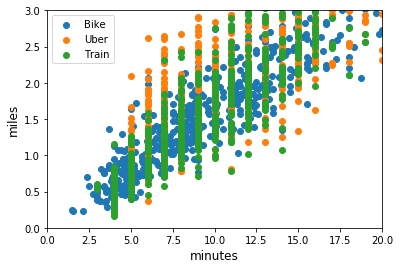

In [190]:
# Plot the trip distances (miles) vs. time (all three modes)

bikeMinsArr = []
uberMinsArr = []
trainMinsArr = []

bikeMinsDist = []
uberMinsDist = []
trainMinsDist = []


def getMinimum(entry_mt):
    bikeMins = entry_mt['bikeMins']
    uberMins = entry_mt['uberMins']
    trainMins = entry_mt['trainMins']
    minNum = np.argmin([bikeMins,trainMins,uberMins])
    if minNum == 0:
        return (0,bikeMins)
    if minNum == 1:
        return (1,trainMins)
    if minNum == 2:
        return (2,uberMins)


for idx_mt, entry_mt in mainTestOutputWithUberDF.iterrows():
    minNum = getMinimum(entry_mt)[0]
    minNumValue = getMinimum(entry_mt)[1]
    if minNum == 0:
        bikeMinsArr.append(minNumValue)
        bikeMinsDist.append(entry_mt["uberTripDistance"])
    if minNum == 1:
        uberMinsArr.append(minNumValue)
        uberMinsDist.append(entry_mt["uberTripDistance"])
    if minNum == 2:
        trainMinsArr.append(minNumValue)
        trainMinsDist.append(entry_mt["uberTripDistance"])

    
# print(bikeMinsDist)
    
plt.scatter(x = bikeMinsArr,y = bikeMinsDist)
plt.scatter(x = uberMinsArr,y = uberMinsDist)
plt.scatter(x = trainMinsArr,y = trainMinsDist)


# plt.scatter(x = mainTestOutputWithUberDF['uberMins'],y = mainTestOutputWithUberDF['uberTripDistance'], alpha = 0.4)
# plt.plot(x = mainTestOutputWithUberDF['trainMins'],y = mainTestOutputWithUberDF['uberTripDistance'], alpha = 0.4)
# fig.suptitle('Travel Time per Mile', fontsize=20)
plt.xlabel('minutes', fontsize=12)
plt.ylabel('miles', fontsize=12)
plt.legend(["Bike","Uber","Train"])
# Remove outliers
plt.xlim(0,20)#minutes
plt.ylim(0,3) #miles



In [202]:
bikeGraph = nx.Graph()

# Add in all the bike docking station nodes.
for s_id, dockingStation in bikeDockingStations.iterrows():
    
     
    # center of city lat,long
    # originLatLong
    #
    # Can draw it to see!
    #    coorDistance = math.sqrt((randLat1 - randLat2)**2 + ((randLong1 - randLong2)*(70/111))**2)*(68.9722)
    
    center = (51.510776, -0.115638) # Center of London

    distToCenterMiles = math.sqrt((center[0] - dockingStation["station__lat"])**2 
                                + ((center[1] - dockingStation["station__long"])*(70/111))**2)*(68.9722)
    

    bikeGraph.add_node(s_id, 
                        coordinates=(dockingStation["station__lat"],
                                     dockingStation["station__long"]), 
                        distToCenter=distToCenterMiles,
                        name=dockingStation['station__name'])


        
for t_id, trip in mainTestOutputWithUberDF.iterrows():
    bikeGraph.add_edge(trip["oBike"], 
                       trip["dBike"], 
                       weight=trip['uberTripDistance'],
                       bikeMins=trip['bikeMins'], 
                       trainMins=trip['trainMins'], 
                       uberMins=trip['uberMins'])
    
    
    
    
#     startLocation = trip['oBike']
#     endLocation = trip['dBike']
#     bikeUberGraph.add_node(1, time='5pm')#     tubeGraph.add_edge(startLocation, endLocation)

In [201]:
# This block draws three identical graphs, 
# but for each one only draws the edge if it's the 
# quickest route for that mode of transport (bike, train, uber)

####################### Experiment Variables ##############################
minDist = 0
maxDist = 10         #set to 0,10 to ignore

minCenterDist = 0.5
maxCenterDist = 1   #set to 0,10 to ignore
###########################################################################

bNum = 0
gNum = 0
oNum = 0


def minTimeModeOfTransportColor(edge):
    bikeMins = bikeGraph[edge[0]][edge[1]]['bikeMins'] #0 - Blue
    trainMins = bikeGraph[edge[0]][edge[1]]['trainMins'] #1 - Green
    uberMins = bikeGraph[edge[0]][edge[1]]['uberMins'] #2 - Orange
    minNum = np.argmin([bikeMins,trainMins,uberMins])
    if minNum == 0:
        return "blue"
    if minNum == 1:
        return "green"
    if minNum == 2:
        return "orange"
    


    
# nx.draw(bikeGraph, nx.get_node_attributes(bikeGraph, 'coordinates'), with_labels=False)


normalize = bikeDockingStations[['station__lat', 'station__long']]
normalize = normalize - normalize.min()
normalize = normalize / normalize.max()+1

locations = dict(zip(bikeDockingStations.index, normalize[['station__lat', 'station__long']].values))

# b = figure(
#     x_range = (-0.1,1.5),
#     y_range = (-0.5,1.5),
#     height= 1000,
#     width= 1000,
# )

# g = figure(
#     x_range = (-0.1,1.5),
#     y_range = (-0.5,1.5),
#     height= 1000,
#     width= 1000,
# )

# o = figure(
#     x_range = (-0.1,1.5),
#     y_range = (-0.5,1.5),
#     height= 1000,
#     width= 1000,
# )

master = figure(
    x_range = (-0.1,1.5),
    y_range = (-0.5,1.5),
    height= 1000,
    width= 1000,
)

for edge in bikeGraph.edges():
    
    routeColor = minTimeModeOfTransportColor(edge)
    
    #Only plot for certain ranges of total distances traveled
    if bikeGraph[edge[0]][edge[1]]['weight'] < minDist or bikeGraph[edge[0]][edge[1]]['weight'] > maxDist:
        continue
        
    #### TODO: Only if origin/destination are in some travel band from city center
    distToTheCenterOrigin = bikeGraph.node[edge[0]]['distToCenter']
    distToTheCenterDest = bikeGraph.node[edge[1]]['distToCenter']

    #Only if it's within the appropriate band of the city center
    if (distToTheCenterOrigin < minCenterDist) or (distToTheCenterOrigin > maxCenterDist) or (distToTheCenterDest < minCenterDist) or (distToTheCenterDest > maxCenterDist):
        continue
    
        
    master.line( 
        x= [locations[pt][0] for pt in edge],
        y= [locations[pt][1] for pt in edge],
        color=routeColor,
        )
    
    if routeColor == 'blue':
        bNum += 1
    elif routeColor == 'green':
        gNum += 1
    else:
        oNum +=1
    

#     if minTimeModeOfTransportColor(edge) == 'blue':
#         b.line( 
#             x= [locations[pt][0] for pt in edge],
#             y= [locations[pt][1] for pt in edge],
#             color='blue',
#         )
#     elif minTimeModeOfTransportColor(edge) == 'orange':
#         o.line( 
#             x= [locations[pt][0] for pt in edge],
#             y= [locations[pt][1] for pt in edge],
#             color="orange",
#         )
#     else:
#         g.line( 
#             x= [locations[pt][0] for pt in edge],
#             y= [locations[pt][1] for pt in edge],
#             color="green",
#         )
 
    
for node in bikeGraph.nodes():
    x = [locations[node][0]]
    y = [locations[node][1]]
    
    distToTheCenter = bikeGraph.node[node]['distToCenter']
    #Only if it's within the appropriate band of the city center
    if distToTheCenter < minCenterDist or distToTheCenter > maxCenterDist:
        continue
    
    
    master.circle(
        x, y, 
        radius = 0.003, 
        fill_color = "gray", 
        line_alpha=0)

    master.text(
        x, y, 
        text = {'value':str(node)}, 
        text_font_size = str(5) + "pt", 
        text_alpha = 1,
        text_align='center',
        text_font_style='bold')
    
    
    
#     b.circle(
#         x, y, 
#         radius = 0.003, 
#         fill_color = "gray", 
#         line_alpha=0)

#     b.text(
#         x, y, 
#         text = {'value':str(node)}, 
#         text_font_size = str(5) + "pt", 
#         text_alpha = 1,
#         text_align='center',
#         text_font_style='bold')
#     ###########################
#     o.circle(
#         x, y, 
#         radius = 0.003, 
#         fill_color = "gray", 
#         line_alpha=0)

#     o.text(
#         x, y, 
#         text = {'value':str(node)}, 
#         text_font_size = str(5) + "pt", 
#         text_alpha = 1,
#         text_align='center',
#         text_font_style='bold')
#     ##############################
#     g.circle(
#         x, y, 
#         radius = 0.003, 
#         fill_color = "gray", 
#         line_alpha=0)

#     g.text(
#         x, y, 
#         text = {'value':str(node)}, 
#         text_font_size = str(5) + "pt", 
#         text_alpha = 1,
#         text_align='center',
#         text_font_style='bold')
        
        
#Plot city center
master.circle(
    1.6,
    1.51, 
    radius = 0.003, 
    fill_color = "yellow",         
    line_alpha=0)

# b.savefig("bike-"+str(minDist)+"-"+str(maxDist)+".png")
#show(b) #BIKE

# o.savefig("uber-"+str(minDist)+"-"+str(maxDist)+".png")
#show(o) #UBER

# g.savefig("train-"+str(minDist)+"-"+str(maxDist)+".png")
#show(g) #TRAINS

# plt.savefig("master-"+str(minDist)+"-"+str(maxDist)+".png")
show(master)

print("range",minDist,maxDist)
print("proximityToCenter",minCenterDist,maxCenterDist)
print("Bike total", bNum)
print("Uber total", oNum)
print("Train total", gNum)

range 0 10
proximityToCenter 0.5 1
Bike total 27
Uber total 4
Train total 11


In [109]:
 #print(nx.clustering(bikeGraph))